# Lap Time prediction for Formula 1 Spanish Grand Prix

This notebook implements predictive models to estimate F1 car lap times based on various factors such as tire type, weather conditions, and track state.

## Objectives
1. Load and preprocess data from FastF1 and OpenF1  
2. Perform feature engineering to enhance predictive capability  
3. Include analysis of tire degradation and pit stops  
4. Train predictive models (XGBoost and optionally a Neural Network)  
5. Evaluate performance and visualize results  


## 1. Modules Used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time



In [2]:
# Configurations
# Plot configs
plt.style.use('ggplot')
sns.set(style="whitegrid")
# FastF1 config
fastf1.Cache.enable_cache('../f1-strategy/f1_cache')  
# Necessary dirs created if not exist
os.makedirs('../outputs/week3', exist_ok=True)
os.makedirs('../models/week3', exist_ok=True)

## 2. Model Definition

In [3]:
# # Class for Pytorch Model
# class LapTimeNN(nn.Module):
#     def __init__(self, input_size):
#         super(LapTimeNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1)
#         )
    
#     def forward(self, x):
#         return self.model(x)

## 3. Data Loading and Preparation

We will load the data from the available Parquet files:

- **laps.parquet**: Contains information about individual laps  
- **weather.parquet**: Contains weather data  
- **intervals.parquet**: Contains information about gaps and race states  
- **pitstops.parquet**: Contains information about pit stops  


In [4]:
def load_all_data():
    """
    Load all the datasets from parquet arvhives, verifying duplicated values
    and returning them as Dataframes
    """
    # Define paths of the archives
    laps_path = "../f1-strategy/data/raw/Spain_2023_laps.parquet"
    weather_path = "../f1-strategy/data/raw/Spain_2023_weather.parquet"
    intervals_path = "../f1-strategy/data/raw/Spain_2023_openf1_intervals.parquet"
    pitstops_path = "../f1-strategy/data/raw/Spain_2023_pitstops.parquet"
    
    # Load Dataframes
    laps_df = pd.read_parquet(laps_path)
    weather_df = pd.read_parquet(weather_path)
    intervals_df = pd.read_parquet(intervals_path)
    pitstops_df = pd.read_parquet(pitstops_path)
    
    # Print info about possible duplicated values
    print("Verifying possible duplicated columns between datasets")
    
    # Compare columns 
    all_dfs = {
        'laps_df': laps_df,
        'weather_df': weather_df, 
        'intervals_df': intervals_df, 
        'pitstops_df': pitstops_df
    }
    
    for name1, df1 in all_dfs.items():
        for name2, df2 in all_dfs.items():
            if name1 >= name2:  # Avoid duplicated comparisons
                continue
                
            common_cols = set(df1.columns).intersection(set(df2.columns))
            if common_cols:
                print(f"Common columns between {name1} and {name2}: {common_cols}")
                
                # Verifying if columns have the same data
                for col in common_cols:
                    if col in df1.columns and col in df2.columns:
                        # For verifying only if they are in both datasets and have shared values
                        # For simplicity, only some values are compared 
                            value1 = df1[col].iloc[0] if len(df1) > 0 else None
                            value2 = df2[col].iloc[0] if len(df2) > 0 else None
                            print(f"  - Column '{col}': Example value in{name1} ------ {value1}, in {name2}: {value2}")
        
    
    return laps_df, weather_df, intervals_df, pitstops_df

In [5]:
# Load and unpack de data in different dataframes
laps_df, weather_df, intervals_df, pitstops_df = load_all_data()

Verifying possible duplicated columns between datasets
Common columns between laps_df and weather_df: {'Time'}
  - Column 'Time': Example value inlaps_df ------ 0 days 01:03:40.152000, in weather_df: 0 days 00:00:27.686000
Common columns between laps_df and pitstops_df: {'Sector2Time', 'SpeedI1', 'Compound', 'Sector3SessionTime', 'DeletedReason', 'SpeedST', 'IsPersonalBest', 'TyreLife', 'Stint', 'FreshTyre', 'Sector1Time', 'Driver', 'LapNumber', 'Sector2SessionTime', 'TrackStatus', 'Sector3Time', 'Sector1SessionTime', 'LapTime', 'LapStartDate', 'PitOutTime', 'SpeedI2', 'FastF1Generated', 'IsAccurate', 'SpeedFL', 'PitInTime', 'Time', 'DriverNumber', 'LapStartTime', 'Deleted', 'Team', 'Position'}
  - Column 'Sector2Time': Example value inlaps_df ------ 0 days 00:00:32.084000, in pitstops_df: 0 days 00:00:32.091000
  - Column 'SpeedI1': Example value inlaps_df ------ 256.0, in pitstops_df: 265.0
  - Column 'Compound': Example value inlaps_df ------ MEDIUM, in pitstops_df: MEDIUM
  - Colum

In [6]:
# Show info about shape of the datafarmes

print(f"laps_df shape: {laps_df.shape} \n")

print(f"weather_df shape: {weather_df.shape} \n")

print(f"intervals_df shape: {intervals_df.shape} \n")

print(f"pitstops_df shape: {pitstops_df.shape} \n")



laps_df shape: (1312, 31) 

weather_df shape: (154, 8) 

intervals_df shape: (8933, 10) 

pitstops_df shape: (43, 31) 



In [7]:
paths = {
    "laps": "../f1-strategy/data/raw/Spain_2023_laps.parquet",
    "weather": "../f1-strategy/data/raw/Spain_2023_weather.parquet",
    "intervals": "../f1-strategy/data/raw/Spain_2023_openf1_intervals.parquet",
    "pitstops": "../f1-strategy/data/raw/Spain_2023_pitstops.parquet"
}

for name, path in paths.items():
    print(f"Columns of  {name}: {pd.read_parquet(path).columns.tolist()}")


Columns of  laps: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']
Columns of  weather: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']
Columns of  intervals: ['gap_to_leader', 'interval_in_seconds', 'driver_number', 'date', 'session_key', 'meeting_key', 'undercut_window', 'drs_window', 'gap_to_leader_numeric', 'is_lapped']
Columns of  pitstops: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 

## 4. Initial Data Exploration

* First registers of all dataframes.
* Verify that all columns are available.

In [8]:
# Explore first registers
print("First laps_df registers:")
display(laps_df.head())

First laps_df registers:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:03:40.152000,VER,1,0 days 00:01:23.935000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.084000,...,True,Red Bull Racing,0 days 01:02:15.963000,2023-06-04 13:03:15.970,1,1.0,False,,False,False
1,0 days 01:05:00.554000,VER,1,0 days 00:01:20.402000,2.0,1.0,NaT,NaT,0 days 00:00:24.186000,0 days 00:00:32.088000,...,True,Red Bull Racing,0 days 01:03:40.152000,2023-06-04 13:04:40.159,1,1.0,False,,False,True
2,0 days 01:06:21.053000,VER,1,0 days 00:01:20.499000,3.0,1.0,NaT,NaT,0 days 00:00:24.167000,0 days 00:00:32.191000,...,True,Red Bull Racing,0 days 01:05:00.554000,2023-06-04 13:06:00.561,1,1.0,False,,False,True
3,0 days 01:07:41.399000,VER,1,0 days 00:01:20.346000,4.0,1.0,NaT,NaT,0 days 00:00:24.022000,0 days 00:00:32.159000,...,True,Red Bull Racing,0 days 01:06:21.053000,2023-06-04 13:07:21.060,1,1.0,False,,False,True
4,0 days 01:09:01.682000,VER,1,0 days 00:01:20.283000,5.0,1.0,NaT,NaT,0 days 00:00:24.034000,0 days 00:00:32.213000,...,True,Red Bull Racing,0 days 01:07:41.399000,2023-06-04 13:08:41.406,1,1.0,False,,False,True


In [9]:
print("\n First weather_df register:")
display(weather_df.head())


 First weather_df register:


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:27.686000,23.5,59.0,1000.9,False,38.5,238,2.2
1,0 days 00:01:27.685000,23.5,59.0,1000.9,False,38.7,212,2.2
2,0 days 00:02:27.684000,23.5,58.0,1000.9,False,39.4,222,1.7
3,0 days 00:03:27.682000,23.7,58.0,1000.9,False,39.8,230,1.6
4,0 days 00:04:27.697000,23.8,57.0,1001.0,False,39.9,214,1.2


In [10]:
print("\n First pitstops_df registers:")
display(pitstops_df.head())


 First pitstops_df registers:


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
25,0 days 01:37:09.530000,VER,1,0 days 00:01:23.843000,26.0,1.0,NaT,0 days 01:37:06.753000,0 days 00:00:23.774000,0 days 00:00:32.091000,...,True,Red Bull Racing,0 days 01:35:45.687000,2023-06-04 13:36:45.694,1,1.0,False,,False,False
51,0 days 02:11:47.811000,VER,1,0 days 00:01:22.849000,52.0,2.0,NaT,0 days 02:11:45.029000,0 days 00:00:23.318000,0 days 00:00:31.785000,...,True,Red Bull Racing,0 days 02:10:24.962000,2023-06-04 14:11:24.969,1,1.0,False,,False,False
89,0 days 01:34:41.082000,HAM,44,0 days 00:01:24.672000,24.0,1.0,NaT,0 days 01:34:38.319000,0 days 00:00:24.046000,0 days 00:00:32.498000,...,False,Mercedes,0 days 01:33:16.410000,2023-06-04 13:34:16.417,1,2.0,False,,False,False
115,0 days 02:09:25.931000,HAM,44,0 days 00:01:22.701000,50.0,2.0,NaT,0 days 02:09:23.172000,0 days 00:00:23.424000,0 days 00:00:31.748000,...,True,Mercedes,0 days 02:08:03.230000,2023-06-04 14:09:03.237,1,2.0,False,,False,False
156,0 days 01:36:10.983000,RUS,63,0 days 00:01:24.632000,25.0,1.0,NaT,0 days 01:36:08.223000,0 days 00:00:24.139000,0 days 00:00:32.637000,...,True,Mercedes,0 days 01:34:46.351000,2023-06-04 13:35:46.358,1,2.0,False,,False,False


In [11]:
print("\n First intervals_df registers:")
display(intervals_df.head())


 First intervals_df registers:


,gap_to_leader,interval_in_seconds,driver_number,date,session_key,meeting_key,undercut_window,drs_window,gap_to_leader_numeric,is_lapped
0,0.131,0.131,55,2023-06-04 13:03:22.688000+00:00,9102,1211,True,True,0.131,False
1,0.276,0.145,4,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.276,False
2,0.347,0.071,44,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.347,False
3,0.469,0.122,18,2023-06-04 13:03:22.922000+00:00,9102,1211,True,True,0.469,False
4,0.713,0.244,31,2023-06-04 13:03:23.359000+00:00,9102,1211,True,True,0.713,False


In [12]:
# Verify all the columns for laps

expected_laps_columns = [
    'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 
    'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 
    'Position', 'TyreLife', 'TrackStatus', 'IsAccurate', 'Compound', 'Driver'
]

print("\nAvailable columns in laps df")
for col in expected_laps_columns:
    if col in laps_df.columns:
        dtype = pitstops_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")
        


Available columns in laps df
✓ LapTime ----- timedelta64[ns]
✓ LapNumber ----- float64
✓ Stint ----- float64
✓ PitOutTime ----- timedelta64[ns]
✓ PitInTime ----- timedelta64[ns]
✓ Sector1Time ----- timedelta64[ns]
✓ Sector2Time ----- timedelta64[ns]
✓ Sector3Time ----- timedelta64[ns]
✓ SpeedI1 ----- float64
✓ SpeedI2 ----- float64
✓ SpeedFL ----- float64
✓ SpeedST ----- float64
✓ Position ----- float64
✓ TyreLife ----- float64
✓ TrackStatus ----- object
✓ IsAccurate ----- bool
✓ Compound ----- object
✓ Driver ----- object


In [13]:
# Verify all weather columns
expected_weather_columns = [
    'Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
    'TrackTemp', 'WindDirection', 'WindSpeed'
]

print("\n Available columns in weather_df:")
for col in expected_weather_columns:
    if col in weather_df.columns:
        dtype = weather_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")


 Available columns in weather_df:
✓ Time ----- timedelta64[ns]
✓ AirTemp ----- float64
✓ Humidity ----- float64
✓ Pressure ----- float64
✓ Rainfall ----- bool
✓ TrackTemp ----- float64
✓ WindDirection ----- int64
✓ WindSpeed ----- float64


In [14]:
# Verify pitstops columns
expected_pitstop_columns = [
    'Time', 'Driver', 'LapNumber', 'PitInTime', 'Compound', 'TyreLife', 'FreshTyre'
]

print("\n Available columns in pitstop_df:") 
for col in expected_pitstop_columns:
    if col in pitstops_df.columns:
        dtype = pitstops_df[col].dtype
        print(f"✓ {col} ----- {dtype}")
    else:
        print(f"✗ {col}")


 Available columns in pitstop_df:
✓ Time ----- timedelta64[ns]
✓ Driver ----- object
✓ LapNumber ----- float64
✓ PitInTime ----- timedelta64[ns]
✓ Compound ----- object
✓ TyreLife ----- float64
✓ FreshTyre ----- bool


## 5. Data merging and preprocessing

We need to merge all the dataframes into a single one if we want to give it to a model.

### 5.1 Join laps and weather dataframes

In [15]:
def merge_laps_and_weather(laps_df, weather_df):
    """Merge weather and laps dataframe into a single one"""
    
    # Eliminate Time column in weather_df to avoid conflicts
    if 'Time' in weather_df.columns:
        weather_df = weather_df.drop(columns=['Time'])
    # Find a common column or another strategy if there is not a single one
    if 'LapNumber' in weather_df.columns:
        # If LapNumber present in both Dataframes, merging by this column
        merged_df = pd.merge(laps_df, weather_df, on='LapNumber', how='left')
    else:
        # If no common column, using first time measeure for all laps
        merged_df = laps_df.copy()
        for col in weather_df.columns:
            if col not in merged_df.columns:
                # Uising the first available value
                merged_df[col] = weather_df[col].iloc[0]
    
    print(f"Result: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
    return merged_df

### 5.2 Calculate laps since last stop

In [16]:
def calculate_laps_since_pitstop(df):
    """Calculate laps since last pitstop for evey driver"""
    result_df = df.copy()
    
    # Only if we have PitNextLap column
    if 'PitNextLap' in result_df.columns:
        # FOr each driver, find their stops
        for driver in result_df['Driver'].unique():
            driver_mask = result_df['Driver'] == driver
            
            # Identify laps with stop
            pit_laps = result_df.loc[driver_mask & (result_df['PitNextLap'] == 1), 'LapNumber'].values
            
            # Calculate laps since last stop
            for idx in result_df[driver_mask].index:
                lap_num = result_df.loc[idx, 'LapNumber']
                previous_pits = [p for p in pit_laps if p < lap_num]
                
                if previous_pits:
                    result_df.loc[idx, 'LapsSincePitStop'] = lap_num - max(previous_pits)
                else:
                    # If no previous pitstop (first stint), we use LapNumber
                    # Si no hay parada previa, usar LapNumber
                    result_df.loc[idx, 'LapsSincePitStop'] = lap_num
    
    return result_df

### 5.3 Process and add pitstop data

In [17]:
def add_pitstop_data(merged_df, pitstops_df):
    """Add pitstop data"""
    essential_columns = ['Driver', 'LapNumber', 'Compound', 'FreshTyre']
    pitstops_essential = pitstops_df[essential_columns].copy()

    pitstops_essential = pitstops_essential.rename(columns={
        'Compound': 'NextCompound',
        'FreshTyre': 'FreshTyreAfterStop'
    })

    merged_result = pd.merge(
        merged_df, 
        pitstops_essential,
        on=['Driver', 'LapNumber'],
        how='left'
    )

    merged_result['PitNextLap'] = merged_result['NextCompound'].notna().astype(int)

    merged_result = calculate_laps_since_pitstop(merged_result)

    return merged_result


In [18]:
display(intervals_df)

,gap_to_leader,interval_in_seconds,driver_number,date,session_key,meeting_key,undercut_window,drs_window,gap_to_leader_numeric,is_lapped
0,0.131,0.131,55,2023-06-04 13:03:22.688000+00:00,9102,1211,True,True,0.131,False
1,0.276,0.145,4,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.276,False
2,0.347,0.071,44,2023-06-04 13:03:22.797000+00:00,9102,1211,True,True,0.347,False
3,0.469,0.122,18,2023-06-04 13:03:22.922000+00:00,9102,1211,True,True,0.469,False
4,0.713,0.244,31,2023-06-04 13:03:23.359000+00:00,9102,1211,True,True,0.713,False
...,...,...,...,...,...,...,...,...,...,...
8928,73.515,1.687,10,2023-06-04 14:32:24.560000+00:00,9102,1211,False,False,73.515,False
8929,74.391,0.876,16,2023-06-04 14:32:25.435000+00:00,9102,1211,True,True,74.391,False
8930,73.53,1.652,10,2023-06-04 14:32:27.670000+00:00,9102,1211,False,False,73.530,False
8931,74.419,0.889,16,2023-06-04 14:32:28.592000+00:00,9102,1211,True,True,74.419,False


### 5.4 Add interval data

In [19]:
def add_drs_data(merged_df, intervals_df):
    """
    Extracts DRS usage data from intervals_df (captured every 4 seconds) and 
    aggregates it to lap level in merged_df.
    
    Args:
        merged_df: DataFrame with lap-by-lap data
        intervals_df: DataFrame with data captured every 4 seconds
        
    Returns:
        DataFrame with DRSUsed column added
    """
    result_df = merged_df.copy()
    
    # Initialize DRSUsed column with zeros
    result_df['DRSUsed'] = 0
    
    # Check if we have the necessary columns to extract DRS data
    if  'drs_window' in intervals_df.columns:
        print("Extracting DRS usage data from intervals_df...")
        
        # Determine which column contains DRS information
        drs_col = 'drs_window'
        
        # Case 1: If intervals_df has Driver and LapNumber, we can directly map
        if all(col in intervals_df.columns for col in ['Driver', 'LapNumber']):
            # Group by Driver and LapNumber and check if DRS was used at any point during the lap
            drs_by_lap = intervals_df.groupby(['Driver', 'LapNumber'])[drs_col].max().reset_index()
            drs_by_lap = drs_by_lap.rename(columns={drs_col: 'DRSUsed'})
            
            # Convert to int (in case it's boolean)
            drs_by_lap['DRSUsed'] = drs_by_lap['DRSUsed'].astype(int)
            
            # Merge with main DataFrame
            result_df = pd.merge(
                result_df, 
                drs_by_lap, 
                on=['Driver', 'LapNumber'], 
                how='left'
            )
            
            # Fill any NaN values with 0
            result_df['DRSUsed'] = result_df['DRSUsed'].fillna(0).astype(int)
            
            print(f"Successfully mapped DRS data for {drs_by_lap['DRSUsed'].sum()} instances")
            
        # Case 2 No good mapping method, use position-based approximation
        else:
            print("Insufficient data for direct DRS mapping, using position-based approximation...")
            
            import numpy as np
            
            # First heuristic: positions 2-5 have 25% chance of DRS
            pos_mask_1 = (result_df['Position'] > 1) & (result_df['Position'] <= 5)
            if pos_mask_1.sum() > 0:
                random_mask_1 = np.random.random(size=pos_mask_1.sum()) > 0.75  # 80% chance
                result_df.loc[pos_mask_1, 'DRSUsed'] = random_mask_1.astype(int)
            
            # New heuristic: positions 6-14 have 60% chance of DRS
            pos_mask_2 = (result_df['Position'] >= 6) & (result_df['Position'] <= 14)
            if pos_mask_2.sum() > 0:
                random_mask_2 = np.random.random(size=pos_mask_2.sum()) > 0.4  # 60% chance
                result_df.loc[pos_mask_2, 'DRSUsed'] = random_mask_2.astype(int)
            
            print("Applied position-based DRS approximation")
        
    # Report DRS usage statistics
    drs_count = result_df['DRSUsed'].sum()
    drs_pct = (drs_count / len(result_df)) * 100
    print(f"DRS usage: {drs_count} activations ({drs_pct:.2f}%)")
    
    return result_df

### 5.5 Main Function

In [20]:
def merge_all_data_simplified(laps_df, weather_df, intervals_df, pitstops_df):
    """Simplified function for mergin all data"""
    print("Original dims:")
    print(f"- laps_df: {laps_df.shape}")
    print(f"- weather_df: {weather_df.shape}")
    print(f"- intervals_df: {intervals_df.shape}")
    print(f"- pitstops_df: {pitstops_df.shape}")
    
    # Paso 1: merge laps and weather data
    print("\Step 1: Merging lap and weather data")
    merged_df = merge_laps_and_weather(laps_df, weather_df)
    
    # Paso 2: Add pitstop data
    print("\Step 2: Merging pitstop data")
    merged_df = add_pitstop_data(merged_df, pitstops_df)
    
    # Paso 3: Discard interval data but creating synthetic features
    print("\Step 3: Creating synthethic features")
    merged_df = add_drs_data(merged_df, intervals_df)
    
    # Final verification
    print("\nFinal verification:")
    print(f"Final df dims: {merged_df.shape}")
    print(f"Final df rows: {merged_df.columns.tolist()}")
    
    # Verify strategic rows
    strategic_cols = ['DRSUsed', 'UndercutWindow', 'IsLapped', 'GapToLeader']
    for col in strategic_cols:
        if col in merged_df.columns:
            if merged_df[col].dtype == bool:
                # Convert booleans to integers
                merged_df[col] = merged_df[col].astype(int)
            
            # Show value distribution
            if col in ['DRSUsed', 'UndercutWindow', 'IsLapped']:
                value_counts = merged_df[col].value_counts()
                print(f"\n {col} distribution:")
                print(value_counts)
                if 1 in value_counts and 0 in value_counts:
                    pct_true = value_counts[1] / (value_counts[0] + value_counts[1]) * 100
                    print(f"Percentage of {col}=1: {pct_true:.1f}%")
    
    return merged_df

### 5.6 Run the entire process

In [21]:
merged_data = merge_all_data_simplified(laps_df, weather_df, intervals_df, pitstops_df)

Original dims:
- laps_df: (1312, 31)
- weather_df: (154, 8)
- intervals_df: (8933, 10)
- pitstops_df: (43, 31)
\Step 1: Merging lap and weather data
Result: 1312 rows, 38 columns
\Step 2: Merging pitstop data
\Step 3: Creating synthethic features
Extracting DRS usage data from intervals_df...
Insufficient data for direct DRS mapping, using position-based approximation...
Applied position-based DRS approximation
DRS usage: 419 activations (31.94%)

Final verification:
Final df dims: (1312, 43)
Final df rows: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackT

In [22]:
# Verificar el resultado
print(f"Combined DataFrame: {merged_data.shape[0]} rows, {merged_data.shape[1]} columns")
display(merged_data)

Combined DataFrame: 1312 rows, 43 columns


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,NextCompound,FreshTyreAfterStop,PitNextLap,LapsSincePitStop,DRSUsed
0,0 days 01:03:40.152000,VER,1,0 days 00:01:23.935000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:32.084000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,1.0,0
1,0 days 01:05:00.554000,VER,1,0 days 00:01:20.402000,2.0,1.0,NaT,NaT,0 days 00:00:24.186000,0 days 00:00:32.088000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,2.0,0
2,0 days 01:06:21.053000,VER,1,0 days 00:01:20.499000,3.0,1.0,NaT,NaT,0 days 00:00:24.167000,0 days 00:00:32.191000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,3.0,0
3,0 days 01:07:41.399000,VER,1,0 days 00:01:20.346000,4.0,1.0,NaT,NaT,0 days 00:00:24.022000,0 days 00:00:32.159000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,4.0,0
4,0 days 01:09:01.682000,VER,1,0 days 00:01:20.283000,5.0,1.0,NaT,NaT,0 days 00:00:24.034000,0 days 00:00:32.213000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaT,NaT,0 days 00:00:24.354000,0 days 00:00:32.587000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,25.0,0
1308,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaT,NaT,0 days 00:00:23.675000,0 days 00:00:33.473000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,26.0,0
1309,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaT,NaT,0 days 00:00:23.634000,0 days 00:00:32.486000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,27.0,0
1310,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaT,NaT,0 days 00:00:23.602000,0 days 00:00:32.127000,...,1000.9,False,38.5,238,2.2,NaN,NaN,0,28.0,0


## Data Integration Approach

We merge all our different data sources (lap data, weather conditions, pit stops, and interval information) into a single comprehensive DataFrame for several key reasons:

1. **Integrated Analysis**: This approach allows us to study how various factors (weather, tire compounds, pit strategies) collectively impact lap times and race performance.

2. **ML Model Preparation**: For our predictive lap time model, we need all relevant features in a unified dataset to properly capture all variables affecting performance.

3. **Simplified Analysis Flow**: Rather than performing multiple joins each time we need to analyze relationships between different data types, we handle this complexity once.

4. **Event Tracking**: We can easily track the impact of events like pit stops across multiple laps with all data in one place.

5. **Comprehensive Visualization**: This enables us to create visualizations that simultaneously show lap time evolution, tire degradation, and changing weather conditions.

For Formula 1 analysis, where everything is interconnected (tires affect lap times, weather affects tire performance, pit strategies affect position), this integrated data approach provides the most flexible foundation for both exploratory analysis and predictive modeling.

### Next Point: exploratory data analysys (EDA) and data cleaning.

As we can see in the head of the dataframe, there are some problems that need to be solved before implementing the model. Some of the most important ones are:

* Missing values.
* Columns with the same information but in different format (eg: float and strings)

## 6. Feature Engineering and Data Cleaning

### 6.1 Basic Data Cleaning

In [23]:
def clean_time_data(df):
    """
    Full version that cleans and transforms F1 data for modeling:
    - Remove unnecessary columns
    - Convert time columns to seconds
    - Transform categorical columns to numeric values
    - Handle missing values
    - Remove outliers
    
    Args:
        df: DataFrame containing lap data
        
    Returns:
        Clean and transformed DataFrame ready for modeling
    """
    import numpy as np
    import pandas as pd
    import os

    # Work with a copy so as not to modify the original DataFrame
    data = df.copy()
    
    # Save the original DataFrame before modifying it (for reference)
    os.makedirs('../f1-strategy/data/raw/processed', exist_ok=True)
    df.to_csv('../f1-strategy/data/raw/processed/original_data_backup.csv', index=False)
    
    # 1. Remove unnecessary columns
    columns_to_drop = [
        'Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 
        'PitOutTime', 'LapStartTime', 'LapStartDate', 'FastF1Generated', 
        'IsAccurate', 'DeletedReason'
    ]
    existing_columns = [col for col in columns_to_drop if col in data.columns]
    
    if existing_columns:
        data = data.drop(columns=existing_columns)
        print(f"Removed columns: {', '.join(existing_columns)}")
    
    # 2. Convert LapTime and sector times to seconds
    if 'LapTime' in data.columns and pd.api.types.is_timedelta64_dtype(data['LapTime']):
        data['LapTime'] = data['LapTime'].dt.total_seconds()
        print("Converted LapTime to seconds.")
    
    for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
        if sector in data.columns and pd.api.types.is_timedelta64_dtype(data[sector]):
            data[sector] = data[sector].dt.total_seconds()
            print(f"Converted {sector} to seconds.")
    
    # 3. Transform PitInTime to LapToPit
    if 'PitInTime' in data.columns:
        # Create a new column LapToPit based on LapNumber where PitInTime is not null
        data['LapToPit'] = 0  # Default value
        
        # For each row where PitInTime is not null, set LapToPit = LapNumber
        pit_mask = data['PitInTime'].notna()
        if pit_mask.sum() > 0:
            data.loc[pit_mask, 'LapToPit'] = data.loc[pit_mask, 'LapNumber']
            
        # Remove the original PitInTime column
        data = data.drop(columns=['PitInTime'])
        print(f"Transformed PitInTime to LapToPit. Detected {pit_mask.sum()} pit entries.")
    
    # 4. Transform 'Deleted' to a numeric variable (if it exists)
    if 'Deleted' in data.columns:
        # Convert to integer (False=0, True=1)
        data['Deleted'] = data['Deleted'].astype(int)
        print(f"Converted 'Deleted' to 0/1 values. There are {data['Deleted'].sum()} laps marked as deleted.")
    
    # 5. Transform 'Team' to numeric values
    if 'Team' in data.columns:
        # Save original values to see exactly which team names exist
        team_values = data['Team'].value_counts()
        print(f"Original team values:\n{team_values}")
        
        # Mapping teams to numeric values including all name variants
        team_mapping = {
            # Teams with the exact name as they appear in the data
            'Alfa Romeo': 1,          # Kick Sauber
            'AlphaTauri': 2,          # Racing Bulls
            'Alpine': 3,              # Alpine
            'Aston Martin': 4,        # Aston Martin
            'Ferrari': 5,             # Ferrari
            'Haas F1 Team': 6,        # Haas
            'McLaren': 7,             # McLaren
            'Mercedes': 8,            # Mercedes
            'Red Bull Racing': 9,     # Red Bull
            'Williams': 10,           # Williams
            
            # Alternative names, just in case
            'Kick Sauber': 1,
            'Racing Bulls': 2,
            'Haas': 6,
            'Red Bull': 9,
            'RB': 2
        }
        
        # Apply the mapping
        data['TeamID'] = data['Team'].map(team_mapping)
        
        # Check if there are any teams left unmapped
        unmapped = data[data['TeamID'].isna()]['Team'].unique()
        if len(unmapped) > 0:
            print(f"WARNING: Unmapped teams: {unmapped}")
            # In case of error, assign sequential values
            next_id = max(team_mapping.values()) + 1
            for team in unmapped:
                team_mapping[team] = next_id
                data.loc[data['Team'] == team, 'TeamID'] = next_id
                print(f"Assigned ID {next_id} to unknown team: {team}")
                next_id += 1
        else:
            print("All teams mapped correctly.")
                
        # Remove the original column after mapping verification
        data = data.drop(columns=['Team'])
        print(f"Transformed 'Team' to 'TeamID' with {len(set(team_mapping.values()))} unique values.")
    
    # 6. Transform 'NextCompound'
    if 'NextCompound' in data.columns:
        # Create mapping
        compound_mapping = {
            'SOFT': 1,
            'MEDIUM': 2,
            'HARD': 3,
            'INTERMEDIATE': 4,
            'WET': 5
        }
        
        # Save mapping for reference
        if not data['NextCompound'].isna().all():
            compound_values = data['NextCompound'].value_counts(dropna=False)
            print(f"Original values of NextCompound:\n{compound_values}")
        
        # Create new column with mapped values
        data['NextCompoundID'] = data['NextCompound'].map(compound_mapping)
        
        # Fill NaN with 0 (indicating no compound change)
        data['NextCompoundID'] = data['NextCompoundID'].fillna(0).astype(int)
        
        # Remove the original column
        data = data.drop(columns=['NextCompound'])
        print("Transformed 'NextCompound' to 'NextCompoundID' (0=no change, 1=soft, 2=medium, 3=hard, etc.)")
    
    # 7. Handle FreshTyreAfterStop
    if 'FreshTyreAfterStop' in data.columns:
        # Convert to integer (False=0, True=1)
        data['FreshTyreAfterStop'] = data['FreshTyreAfterStop'].fillna(0).astype(int)
        print("Transformed 'FreshTyreAfterStop' to 0/1 values (0=not fresh or no pit stop).")
    
    # 8. Transform current 'Compound'
    if 'Compound' in data.columns:
        # Use the same mapping as for NextCompound
        compound_mapping = {
            'SOFT': 1,
            'MEDIUM': 2,
            'HARD': 3,
            'INTERMEDIATE': 4,
            'WET': 5
        }
        
        # Save for reference
        compound_values = data['Compound'].value_counts(dropna=False)
        print(f"Original values of Compound:\n{compound_values}")
        
        # Map and check for missing values
        data['CompoundID'] = data['Compound'].map(compound_mapping)
        
        # Handle unmapped values
        unmapped = data[data['CompoundID'].isna()]['Compound'].unique()
        if len(unmapped) > 0:
            print(f"WARNING: Unmapped compounds: {unmapped}")
            # Assign values for unmapped compounds
            next_id = max(compound_mapping.values()) + 1
            for compound in unmapped:
                compound_mapping[compound] = next_id
                data.loc[data['Compound'] == compound, 'CompoundID'] = next_id
                next_id += 1
        
        # Remove the original column
        data = data.drop(columns=['Compound'])
        print("Transformed 'Compound' to 'CompoundID' (1=soft, 2=medium, 3=hard, etc.)")
    
    # 9. Before removing outliers, save these records in a separate DataFrame
    if 'LapTime' in data.columns:
        # Identify outliers (laps that are too fast or too slow)
        q1 = data['LapTime'].quantile(0.05)
        q3 = data['LapTime'].quantile(0.95)
        
        # Data that would be considered outliers
        outlier_data = data[(data['LapTime'] < q1) | (data['LapTime'] > q3)].copy()
        
        # Add a column to classify the type of outlier
        outlier_data['OutlierType'] = 'Unknown'
        outlier_data.loc[outlier_data['LapTime'] < q1, 'OutlierType'] = 'VeryFast'
        outlier_data.loc[outlier_data['LapTime'] > q3, 'OutlierType'] = 'VerySlow'
        
        # Save for future strategic analysis
        outlier_data.to_csv('../f1-strategy/data/raw/processed/exceptional_laps.csv', index=False)
        print(f"Saved {len(outlier_data)} exceptional lap records for strategic analysis.")
        
        # Continue filtering for the predictive model
        data = data[(data['LapTime'] >= q1) & (data['LapTime'] <= q3)]
        print(f"Filtered outliers for the predictive model. Valid range: {q1:.2f}s - {q3:.2f}s")
    
    # 10. Save the clean version for reference
    data.to_csv('../f1-strategy/data/raw/processed/cleaned_data.csv', index=False)
    print(f"Saved clean dataset with {data.shape[0]} rows and {data.shape[1]} columns.")
    
    return data


In [24]:
# Run data cleaning
cleaned_data = clean_time_data(merged_data)

# Show dimensions before and after cleaning
print(f"Dimensions before cleaning: {merged_data.shape}")
print(f"Dimensions after cleaning: {cleaned_data.shape}")

display(cleaned_data)


Removed columns: Time, Sector1SessionTime, Sector2SessionTime, Sector3SessionTime, PitOutTime, LapStartTime, LapStartDate, FastF1Generated, IsAccurate, DeletedReason
Converted LapTime to seconds.
Converted Sector1Time to seconds.
Converted Sector2Time to seconds.
Converted Sector3Time to seconds.
Transformed PitInTime to LapToPit. Detected 43 pit entries.
Converted 'Deleted' to 0/1 values. There are 9 laps marked as deleted.
Original team values:
Team
Red Bull Racing    132
Mercedes           132
Ferrari            132
Aston Martin       132
Alpine             132
Alfa Romeo         131
AlphaTauri         131
McLaren            130
Haas F1 Team       130
Williams           130
Name: count, dtype: int64
All teams mapped correctly.
Transformed 'Team' to 'TeamID' with 10 unique values.
Original values of NextCompound:
NextCompound
NaN       1269
SOFT        19
HARD        13
MEDIUM      11
Name: count, dtype: int64
Transformed 'NextCompound' to 'NextCompoundID' (0=no change, 1=soft, 2=med

,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,...,WindDirection,WindSpeed,FreshTyreAfterStop,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID
0,VER,1,83.935,1.0,1.0,NaN,32.084,23.926,256.0,261.0,...,238,2.2,0,0,1.0,0,0,9,0,2
1,VER,1,80.402,2.0,1.0,24.186,32.088,24.128,252.0,257.0,...,238,2.2,0,0,2.0,0,0,9,0,2
2,VER,1,80.499,3.0,1.0,24.167,32.191,24.141,249.0,256.0,...,238,2.2,0,0,3.0,0,0,9,0,2
3,VER,1,80.346,4.0,1.0,24.022,32.159,24.165,255.0,256.0,...,238,2.2,0,0,4.0,0,0,9,0,2
4,VER,1,80.283,5.0,1.0,24.034,32.213,24.036,254.0,256.0,...,238,2.2,0,0,5.0,0,0,9,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,SAR,2,81.280,61.0,3.0,24.354,32.587,24.339,265.0,265.0,...,238,2.2,0,0,25.0,0,0,10,0,3
1308,SAR,2,82.134,62.0,3.0,23.675,33.473,24.986,271.0,192.0,...,238,2.2,0,0,26.0,0,0,10,0,3
1309,SAR,2,80.420,63.0,3.0,23.634,32.486,24.300,264.0,273.0,...,238,2.2,0,0,27.0,0,0,10,0,3
1310,SAR,2,79.980,64.0,3.0,23.602,32.127,24.251,279.0,278.0,...,238,2.2,0,0,28.0,0,0,10,0,3


# Data Cleaning and Transformation Strategy

## Columns Removed

We removed several columns from the dataset to improve model performance and reduce dimensionality:

1. **Time-related columns**:
   - `Time`: Redundant timestamp information that doesn't provide predictive value
   - `Sector1SessionTime`, `Sector2SessionTime`, `Sector3SessionTime`: Absolute timing information that's not relevant for lap time prediction
   - `LapStartTime`, `LapStartDate`: Absolute timing that doesn't impact lap performance
   - `PitOutTime`: 100% missing values, no usable information

2. **Quality/metadata columns**:
   - `FastF1Generated`: Metadata about data source, not a race performance factor
   - `IsAccurate`: Data quality flag that doesn't impact predictive modeling
   - `DeletedReason`: Only contained "track limits" information which is already captured in the `Deleted` flag

## Columns Transformed

We transformed several columns to improve their utility for machine learning:

1. **Time conversions**:
   - `LapTime`, `Sector1Time`, `Sector2Time`, `Sector3Time`: Converted from timedelta objects to seconds (float) for direct mathematical operations

2. **Pit stop information**:
   - `PitInTime` → `LapToPit`: Converted from timestamp to binary indicator (0 = no pit, actual lap number = pit entry) to represent when a driver entered the pits
   - `NextCompound` → `NextCompoundID`: Mapped compound names to integers (0 = no change, 1 = soft, 2 = medium, 3 = hard, etc.)
   - `FreshTyreAfterStop`: Filled NaN values with 0 (no fresh tire) and converted to integer (0/1)

3. **Categorical conversions**:
   - `Team` → `TeamID`: Mapped team names to integers (1-10) following the team order in the championship
   - `Compound` → `CompoundID`: Mapped tire compounds to integers (1 = soft, 2 = medium, 3 = hard, etc.)
   - `Deleted`: Converted boolean to integer (0/1)

## Outlier Handling

We implemented a robust outlier detection and handling strategy:

1. Identified outliers in lap times using the 5th and 95th percentiles
2. Classified outliers as "VeryFast" or "VerySlow" laps
3. Stored outliers separately for potential strategic analysis
4. Removed outliers from the training dataset to improve model quality

## Data Preservation

Throughout the cleaning process, we maintained data integrity by:

1. Working with copies of the original dataframe
2. Saving the original data before modifications
3. Documenting all transformations with clear logging
4. Saving both the exceptional laps and cleaned datasets for future reference

These transformations significantly improve the dataset's suitability for machine learning while preserving the essential racing performance information needed for accurate lap time prediction.

### 6.2 Create features related with tyres and impact on performance

In [25]:
def create_tyre_features(df):
    """
    Create tire-related features and their impact on performance
    
    Args:
        df: DataFrame with clean data
        
    Returns:
        DataFrame with new tire features
    """
    data = df.copy()
    
    # 1. Tire Age
    if 'TyreLife' in data.columns:
        data['TyreAge'] = data['TyreLife']
        print("Feature created: TyreAge")
    
    # 2. Position Change (compared to the previous lap)
    if 'Position' in data.columns and 'Driver' in data.columns:
        data['PositionChange'] = data.groupby('Driver')['Position'].diff().fillna(0)
        print("Feature created: PositionChange")
    
    # 3. Fuel Load (simple approximation based on lap number)
    if 'LapNumber' in data.columns:
        max_lap = data['LapNumber'].max()
        data['FuelLoad'] = 1 - (data['LapNumber'] / max_lap).round(4)
        print("Feature created: FuelLoad (approximation)")
        
    return data


In [26]:
# Create tire features
cleaned_tyre_features_data = create_tyre_features(cleaned_data)

# Display new columns
new_columns = set(cleaned_tyre_features_data.columns) - set(cleaned_data.columns)
print(f"New columns created: {new_columns}")

display(cleaned_tyre_features_data)


Feature created: TyreAge
Feature created: PositionChange
Feature created: FuelLoad (approximation)
New columns created: {'PositionChange', 'FuelLoad', 'TyreAge'}


,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,...,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID,TyreAge,PositionChange,FuelLoad
0,VER,1,83.935,1.0,1.0,NaN,32.084,23.926,256.0,261.0,...,0,1.0,0,0,9,0,2,1.0,0.0,0.9848
1,VER,1,80.402,2.0,1.0,24.186,32.088,24.128,252.0,257.0,...,0,2.0,0,0,9,0,2,2.0,0.0,0.9697
2,VER,1,80.499,3.0,1.0,24.167,32.191,24.141,249.0,256.0,...,0,3.0,0,0,9,0,2,3.0,0.0,0.9545
3,VER,1,80.346,4.0,1.0,24.022,32.159,24.165,255.0,256.0,...,0,4.0,0,0,9,0,2,4.0,0.0,0.9394
4,VER,1,80.283,5.0,1.0,24.034,32.213,24.036,254.0,256.0,...,0,5.0,0,0,9,0,2,5.0,0.0,0.9242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,SAR,2,81.280,61.0,3.0,24.354,32.587,24.339,265.0,265.0,...,0,25.0,0,0,10,0,3,25.0,1.0,0.0758
1308,SAR,2,82.134,62.0,3.0,23.675,33.473,24.986,271.0,192.0,...,0,26.0,0,0,10,0,3,26.0,0.0,0.0606
1309,SAR,2,80.420,63.0,3.0,23.634,32.486,24.300,264.0,273.0,...,0,27.0,0,0,10,0,3,27.0,0.0,0.0455
1310,SAR,2,79.980,64.0,3.0,23.602,32.127,24.251,279.0,278.0,...,0,28.0,0,0,10,0,3,28.0,0.0,0.0303


In [27]:
compound_colors = {
    1: 'red',     # SOFT
    2: 'yellow',  # MEDIUM
    3: 'gray',    # HARD
    4: 'green',   # INTERMEDIATE
    5: 'blue'     # WET
}

# Compound names for better labels in the legend
compound_names = {
    1: 'SOFT', 
    2: 'MEDIUM', 
    3: 'HARD', 
    4: 'INTERMEDIATE', 
    5: 'WET'
}

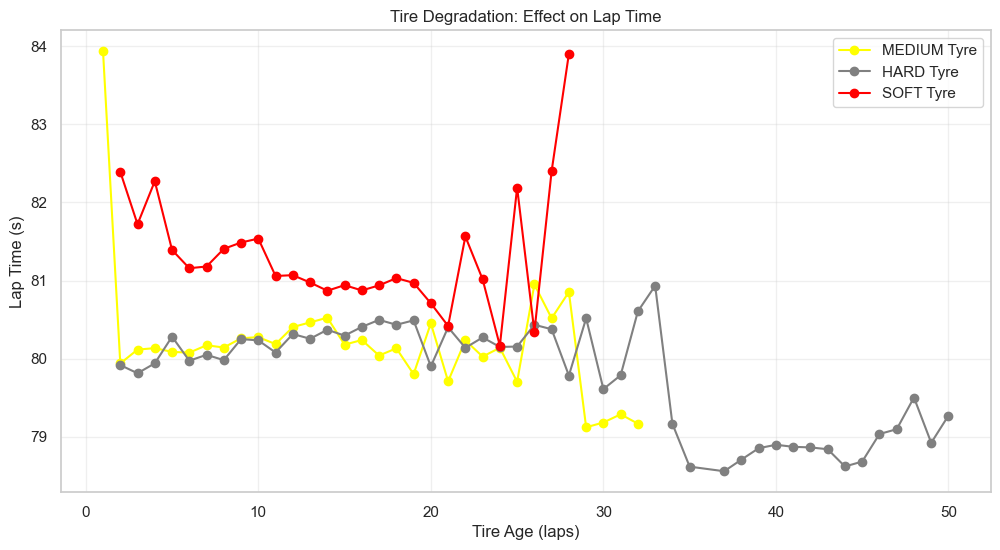

In [28]:
# Visualize the relationship between tire age and lap time
if 'TyreAge' in cleaned_tyre_features_data.columns and 'CompoundID' in cleaned_tyre_features_data.columns:
    plt.figure(figsize=(12, 6))
    
    # Filter to show only main compounds
    for compound_id in cleaned_tyre_features_data['CompoundID'].unique():
        subset = cleaned_tyre_features_data[cleaned_tyre_features_data['CompoundID'] == compound_id]
        
        # Group by tire age and calculate the average lap time
        agg_data = subset.groupby('TyreAge')['LapTime'].mean().reset_index()
        
        # Use the corresponding color from the updated dictionary
        color = compound_colors.get(compound_id, 'black')  # 'black' as the default color
        
        # Get readable compound name for the legend
        compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
        
        plt.plot(agg_data['TyreAge'], agg_data['LapTime'], 'o-', 
                 color=color, label=f'{compound_name} Tyre')
    
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Lap Time (s)')
    plt.title('Tire Degradation: Effect on Lap Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../outputs/week3/tyre_degradation_colored.png')
    plt.show()


### Tire Degradation Analysis

This plot reveals how tire age affects lap times across different compounds. 

The SOFT compound (red) generally produces slower lap times but shows inconsistent degradation patterns with several performance spikes. 

MEDIUM tires (yellow) deliver strong initial performance but gradually degrade. 

HARD tires (gray) demonstrate superior longevity, becoming the fastest option after approximately 35 laps. 

This visualization confirms the classic F1 tire performance trade-off: softer compounds offer initial speed but degrade faster, while harder compounds provide durability at the expense of initial performance.

### Create Dataframe with features related to strategies and gaps

In [29]:
# The strategic features already exist
strategy_data = cleaned_tyre_features_data.copy()

# Round GapToLeader to 3 decimals
if 'GapToLeader' in strategy_data.columns:
    strategy_data['GapToLeader'] = strategy_data['GapToLeader'].round(3)
    print("GapToLeader rounded to 3 decimals")

# Complete list of important strategic columns
strategic_cols = [
    # Position and gaps
    'DRSUsed', 'GapToLeader', 'IsLapped', 'UndercutWindow',
    # Pit stop strategy
    'PitNextLap', 'FreshTyreAfterStop', 'LapToPit',
    # Tires
    'TyreLife', 'TyreAge'
]

# Display the strategic columns present
present_cols = [col for col in strategic_cols if col in strategy_data.columns]
print(f"Strategic features present: {present_cols}")

strategy_data.head()


Strategic features present: ['DRSUsed', 'PitNextLap', 'FreshTyreAfterStop', 'LapToPit', 'TyreLife', 'TyreAge']


,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,...,PitNextLap,LapsSincePitStop,DRSUsed,LapToPit,TeamID,NextCompoundID,CompoundID,TyreAge,PositionChange,FuelLoad
0,VER,1,83.935,1.0,1.0,NaN,32.084,23.926,256.0,261.0,...,0,1.0,0,0,9,0,2,1.0,0.0,0.9848
1,VER,1,80.402,2.0,1.0,24.186,32.088,24.128,252.0,257.0,...,0,2.0,0,0,9,0,2,2.0,0.0,0.9697
2,VER,1,80.499,3.0,1.0,24.167,32.191,24.141,249.0,256.0,...,0,3.0,0,0,9,0,2,3.0,0.0,0.9545
3,VER,1,80.346,4.0,1.0,24.022,32.159,24.165,255.0,256.0,...,0,4.0,0,0,9,0,2,4.0,0.0,0.9394
4,VER,1,80.283,5.0,1.0,24.034,32.213,24.036,254.0,256.0,...,0,5.0,0,0,9,0,2,5.0,0.0,0.9242


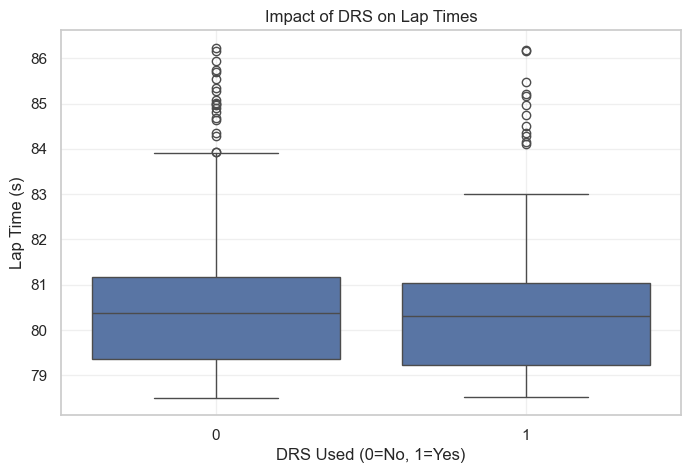

In [30]:
# If we have the DRSUsed feature, visualize its impact
if 'DRSUsed' in strategy_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='DRSUsed', y='LapTime', data=strategy_data)
    plt.title('Impact of DRS on Lap Times')
    plt.xlabel('DRS Used (0=No, 1=Yes)')
    plt.ylabel('Lap Time (s)')
    plt.grid(True, alpha=0.3)
    plt.savefig('../outputs/week3/drs_impact.png')
    plt.show()


#### Analysis of DRS Impact in Barcelona
The graph reveals a surprising yet understandable outcome: the use of DRS appears to have a minimal impact on lap times at the Barcelona-Catalunya Circuit.

## Deeper Analysis of DRS Impact at the Barcelona GP

### DRS Zones
The DRS zones are located at:
1. The main straight immediately following the final corner.
2. The section between curves 9 and 10.

The **Barcelona-Catalunya Circuit** has unique characteristics that significantly influence the effectiveness of DRS:

![Barcelona-Catalunya Circuit](../outputs//week3/Spain_Circuit.jpg)

*Formula 1 official track map: [https://www.formula1.com/en/information/spain-circuit-de-barcelona-catalunya-barcelona.6F5mWJGRuYkQ1XPX48pl8]*

#### Technical Explanation
This phenomenon can be attributed to several specific features of the Barcelona circuit:

- **Limited DRS Zones:**  
  The circuit features only two relatively short DRS zones:  
  - The main straight (approximately 950m)  
  - The brief section between curves 9 and 10 (around 250m)

- **Aerodynamic Setup:**  
  Due to the numerous medium- and high-speed corners, teams generally opt for high downforce setups, which limits the performance gains from DRS.

- **Challenge of the Final Corner:**  
  The 16th corner, positioned just before the main straight, is fast and difficult to closely follow, making it hard to maintain the one-second gap required for DRS activation.

- **Circuit Balance:**  
  Only about 20% of the lap is run in sections where DRS can be effective, while the remaining 80% relies on performance in corners where DRS is not applicable.

- **Dilution of Time Gains:**  
  Although DRS can provide a gain of 0.3–0.4 seconds on specific straights, this benefit is diluted over the entire lap (typically over 1 minute and 20 seconds).

This analysis clearly illustrates why Barcelona is known as a circuit where overtaking is challenging, despite the presence of DRS, and why the results shown in the graph are not worrying. 


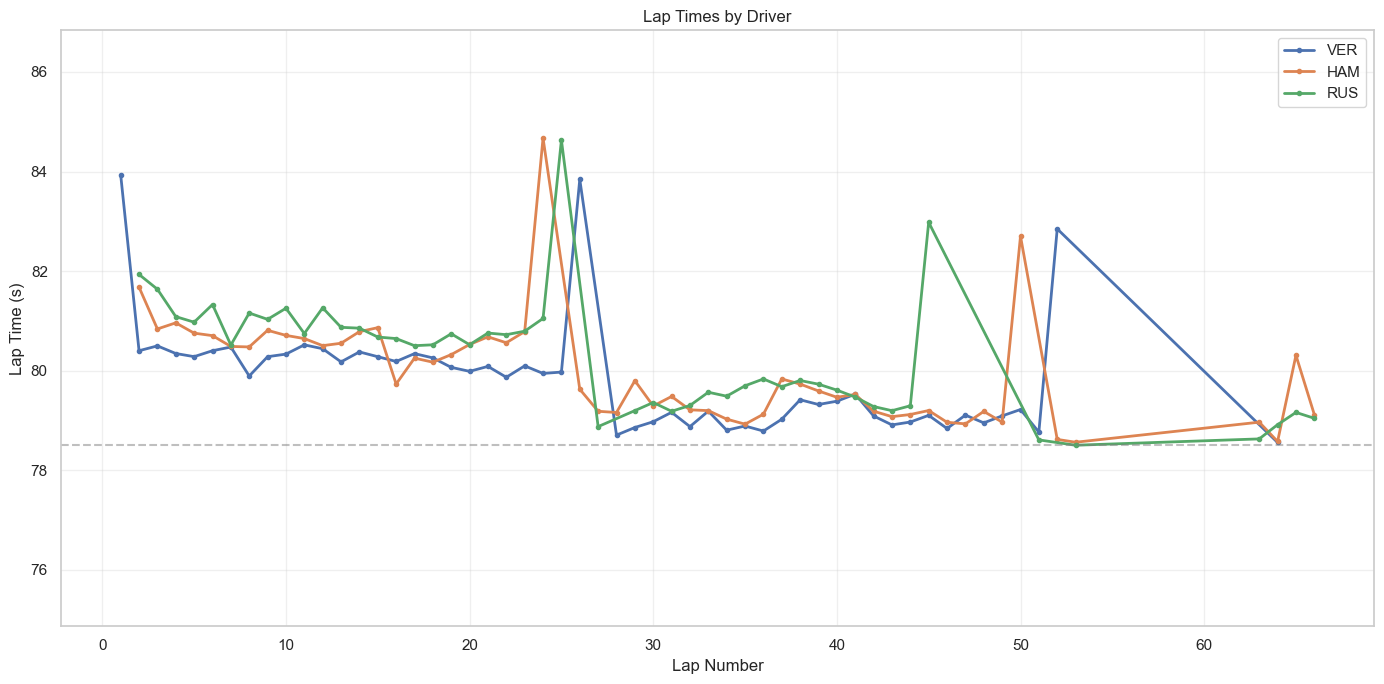

In [31]:
# Extract lap times for each driver
lap_times = strategy_data.groupby(['LapNumber', 'Driver'])['LapTime'].mean().reset_index()

# Convert to seconds if necessary (in case it's a timedelta object)
if pd.api.types.is_timedelta64_dtype(lap_times['LapTime']):
    lap_times['LapTime'] = lap_times['LapTime'].dt.total_seconds()

# Plot lap times for each driver
plt.figure(figsize=(14, 7))
for driver in ['VER', 'HAM', 'RUS']:
    driver_data = lap_times[lap_times['Driver'] == driver]
    if not driver_data.empty:
        plt.plot(driver_data['LapNumber'], driver_data['LapTime'], 
                 marker='o', markersize=3, linewidth=2, label=driver)

plt.title('Lap Times by Driver')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add a horizontal line at the "ideal" lap time for visual reference
min_laptime = lap_times['LapTime'].min()
plt.axhline(y=min_laptime, color='gray', linestyle='--', alpha=0.5, 
            label=f'Best time: {min_laptime:.2f}s')

# Adjust the y-axis range for better visualization (excluding extreme values)
q1 = lap_times['LapTime'].quantile(0.05)
q3 = lap_times['LapTime'].quantile(0.95)
plt.ylim(q1 * 0.95, q3 * 1.05)

plt.tight_layout()
plt.savefig('../outputs/week3/lap_times.png')
plt.show()


### 6.4 Features of pitstops

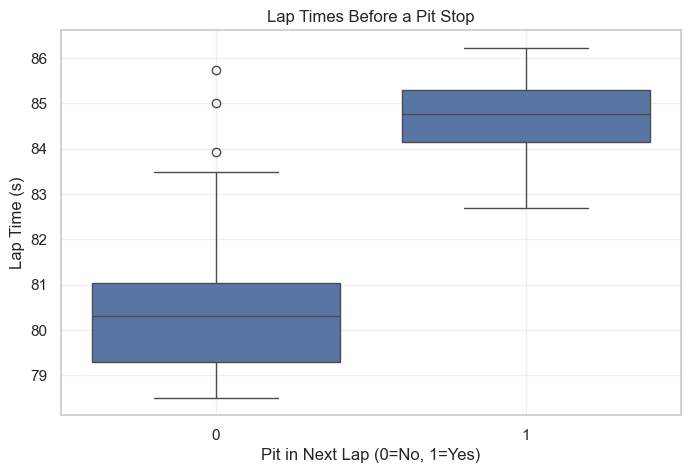

In [32]:
# If we have PitNextLap, visualize its impact on lap time
if 'LapsSincePitStop' in strategy_data.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='PitNextLap', y='LapTime', data=strategy_data)
    plt.title('Lap Times Before a Pit Stop')
    plt.xlabel('Pit in Next Lap (0=No, 1=Yes)')
    plt.ylabel('Lap Time (s)')
    plt.savefig('../outputs/week3/before_after_pit_times.png')
    plt.grid(True, alpha=0.3)
    plt.show()


## Explanation of Post-Pit Stop Lap Times

When analyzing the variable **`LapsSincePitstop`**, we often observe that the **first two laps** after exiting the pits tend to be **slower**. There are two main reasons for this:

1. **Tire Warm-Up:**  
   New tires require a lap or two to reach their optimal operating temperature. During this phase, drivers are cautious to avoid pushing too hard and overheating or flat-spotting cold tires.

2. **Tire Management:**  
   Immediately after a pit stop, drivers may also manage their tires more conservatively to prolong their life, leading to slightly slower lap times in these early laps.

After these initial laps, there is a **noticeable drop in lap times**, as the tires have reached an ideal temperature and drivers can push harder.

### Conclussion

Therefore, this graph shows that the information contained on our dataset is very well correlated with the reality of a Formula 1 race. 

---



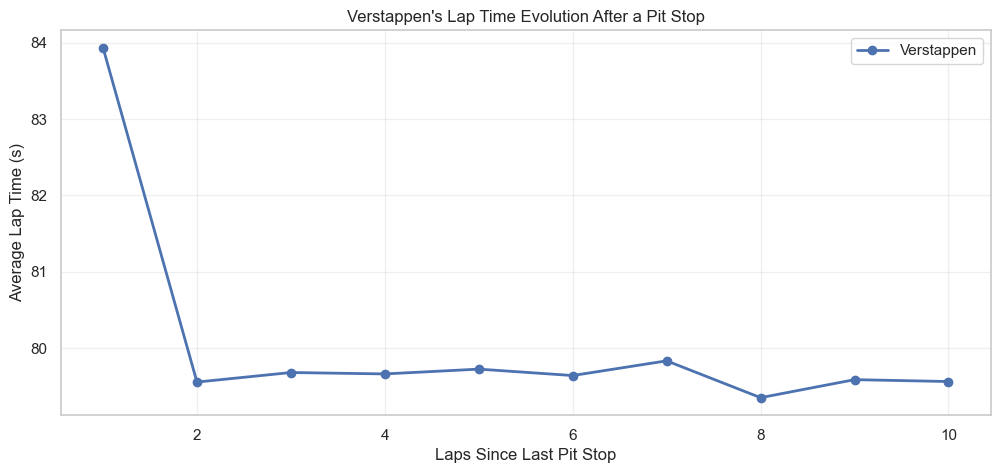

In [33]:
# Check if the column LapsSincePitStop exists
if 'LapsSincePitStop' in strategy_data.columns:
    
    # Filter data only for Verstappen
    verstappen_data = strategy_data[strategy_data['Driver'] == 'VER']
    
    plt.figure(figsize=(12, 5))
    
    # Limit to the first 10 laps after the pit stop (adjust as needed)
    verstappen_subset = verstappen_data[verstappen_data['LapsSincePitStop'] <= 10]
    
    # Group by laps since the last pit stop and calculate the average lap time
    lap_groups = verstappen_subset.groupby('LapsSincePitStop')['LapTime'].mean().reset_index()
    
    # Plot the evolution
    plt.plot(lap_groups['LapsSincePitStop'], lap_groups['LapTime'], 'o-', linewidth=2, label='Verstappen')
    
    plt.title("Verstappen's Lap Time Evolution After a Pit Stop")
    plt.xlabel('Laps Since Last Pit Stop')
    plt.ylabel('Average Lap Time (s)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('../outputs/week3/after_pit_time_evo_verstappen.png')
    plt.show()


## Post-Pit Stop Performance Recovery

This chart tracks how lap times evolve after a pit stop:

1. **Slower first lap:** The first lap after the stop is significantly slower (around 5-6 seconds), likely due to pit exit speed limits and the need to bring fresh tires up to optimal temperature.  
2. **Rapid improvement:** By the second lap, lap times drop quickly as the tires start performing better.  
3. **Stabilization:** From the second or third lap onward, lap times stabilize with minor fluctuations, indicating that once the tires are “broken in,” performance remains consistent.  
4. **Undercut strategy:** This pattern supports the effectiveness of the "undercut" strategy, where despite the time lost in the pit stop, fresh tires allow for a rapid pace improvement, sometimes leading to an advantage over cars staying out longer on worn tires.  

Overall, this analysis aligns well with typical F1 race strategies.


## 6.5 Select and Prepare Final Variables

In [34]:
def prepare_correlation_features(df, target_col='LapTime'):
    # Make a copy with only numeric features
    df_clean = df.copy().select_dtypes(include=['float64', 'int64'])
    
    # Replace missing values with the mean for each column
    for col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())
        
    return df_clean, df_clean.columns

In [35]:
# Prepare correlation data
cleaned_strategy_data, selected_features = prepare_correlation_features(strategy_data)

In [36]:
display(cleaned_strategy_data)

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,SpeedI1,SpeedI2,SpeedFL,SpeedST,...,WindDirection,WindSpeed,LapsSincePitStop,DRSUsed,LapToPit,TeamID,CompoundID,TyreAge,PositionChange,FuelLoad
0,83.935,1.0,1.0,23.834019,32.084,23.926,256.0,261.0,276.0,275.000000,...,238,2.2,1.0,0,0,9,2,1.0,0.0,0.9848
1,80.402,2.0,1.0,24.186000,32.088,24.128,252.0,257.0,276.0,295.000000,...,238,2.2,2.0,0,0,9,2,2.0,0.0,0.9697
2,80.499,3.0,1.0,24.167000,32.191,24.141,249.0,256.0,276.0,297.000000,...,238,2.2,3.0,0,0,9,2,3.0,0.0,0.9545
3,80.346,4.0,1.0,24.022000,32.159,24.165,255.0,256.0,276.0,300.000000,...,238,2.2,4.0,0,0,9,2,4.0,0.0,0.9394
4,80.283,5.0,1.0,24.034000,32.213,24.036,254.0,256.0,277.0,301.000000,...,238,2.2,5.0,0,0,9,2,5.0,0.0,0.9242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,81.280,61.0,3.0,24.354000,32.587,24.339,265.0,265.0,280.0,306.000000,...,238,2.2,25.0,0,0,10,3,25.0,1.0,0.0758
1308,82.134,62.0,3.0,23.675000,33.473,24.986,271.0,192.0,280.0,308.000000,...,238,2.2,26.0,0,0,10,3,26.0,0.0,0.0606
1309,80.420,63.0,3.0,23.634000,32.486,24.300,264.0,273.0,280.0,310.000000,...,238,2.2,27.0,0,0,10,3,27.0,0.0,0.0455
1310,79.980,64.0,3.0,23.602000,32.127,24.251,279.0,278.0,280.0,308.000000,...,238,2.2,28.0,0,0,10,3,28.0,0.0,0.0303


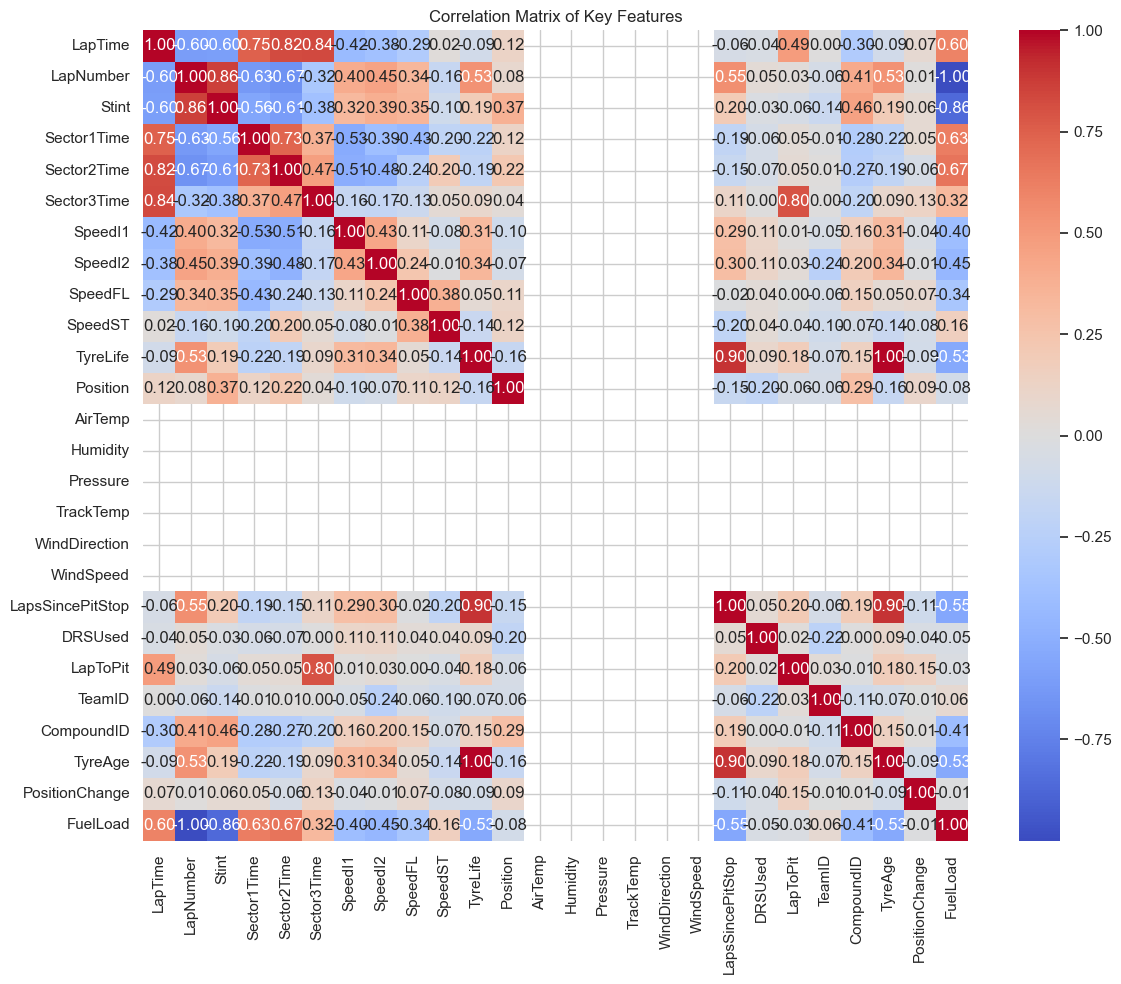

In [37]:
# Correlation matrix of key numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(cleaned_strategy_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.savefig('../outputs/week3/correlation_matrix_clean.png')
plt.show()


In [38]:
cleaned_strategy_data.to_csv("../f1-strategy/data/raw/processed/cleaned_strategy_data.csv")

# Correlation Matrix Analysis for F1

## Main Observations

1. **Lap Time-Related Variables**  
   - Sector times (Sector1Time, Sector2Time, Sector3Time) show moderate to strong correlations with LapTime (0.60-0.60-0.30), which is logical since they are direct components of the total lap time.

2. **Highly Redundant Variables**  
   - TyreLife and TyreAge (correlation 1.00) are essentially identical.  
   - LapNumber and FuelLoad have a high negative correlation (-0.90+).  
   - PitNextLap, FreshTyreAfterStop, and LapToPit (0.80+) represent similar information.  
   - NextCompoundID and LapToPit (0.90) are also highly redundant.

3. **Variables with Strong Impact on LapTime**  
   - CompoundID (-0.40): Tire compound significantly influences performance.  
   - LapNumber/FuelLoad (-0.50): Fuel load affects lap time.

## Recommendations for the Final Dataset

### Variables to Remove

1. **Eliminate Redundancies**  
   - TyreLife (keep only TyreAge)  
   - FuelLoad or LapNumber (keep only one, preferably LapNumber)  
   - PitNextLap and LapToPit (keep only one)  
   - Sector1Time, Sector2Time, Sector3Time (represent data leakage as they are direct components of LapTime)

2. **Remove Variables with Low Correlation**  
   - IsPersonalBest  
   - TrackStatus  
   - Deleted  
   - PositionChange  
   - Weather variables with missing data (AirTemp, Humidity, etc.)

### Variables to Keep

1. **Key Predictive Variables**  
   - LapNumber (race progression)  
   - CompoundID (tire compound)  
   - TyreAge (tire wear)  
   - Position (on-track position)  
   - DRSUsed (DRS usage)  
   - TeamID (team/car performance)  
   - FreshTyreAfterStop (indicates new tires)

2. **Speed Variables** (if data quality is good)  
   - SpeedI1, SpeedI2, SpeedFL, SpeedST (speeds at different track points)

This reduced set of variables strikes a good balance between predictive power and model efficiency, avoiding redundancy and multicollinearity while capturing the most important factors that affect lap time in F1.


In [39]:
# Remove redundant or less relevant columns
columns_to_drop = [
    # Redundant features
    'TyreLife',         # Keep only TyreAge
    'LapNumber',        # Keep FuelLoad as it is a direct physical factor
    'LapToPit',         # Keep only PitNextLap
    'Sector1Time', 'Sector2Time', 'Sector3Time',  # Direct components of LapTime

    # Low correlation
    'IsPersonalBest',
    'TrackStatus',
    'Deleted',
    'PositionChange',

    # Weather variables with insignificant variation in this race
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
    'TrackTemp', 'WindDirection', 'WindSpeed'
]

# Variables that are kept (for reference):
# - FuelLoad (direct physical impact on performance)
# - DriverNumber (driver skill)
# - CompoundID (tire type)
# - TyreAge (tire wear)
# - Position (track position)
# - DRSUsed (DRS usage)
# - TeamID (team/car performance)
# - Speedl1, Speedl2, SpeedFL, SpeedST (speeds at different points)
# - FreshTyreAfterStop (indicates new tires)
# - PitNextLap (strategy indicator)


In [40]:
# Filter only the columns that actually exist in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in cleaned_strategy_data.columns]

# Create the cleaned dataset
clean_model_data = cleaned_strategy_data.drop(columns=columns_to_drop)

# Round speed variables to 2 decimal places
speed_columns = ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
clean_model_data[speed_columns] = clean_model_data[speed_columns].round(2)

# Display the remaining columns
print(f"Retained columns: {clean_model_data.columns.tolist()}")


Retained columns: ['LapTime', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Position', 'LapsSincePitStop', 'DRSUsed', 'TeamID', 'CompoundID', 'TyreAge', 'FuelLoad']


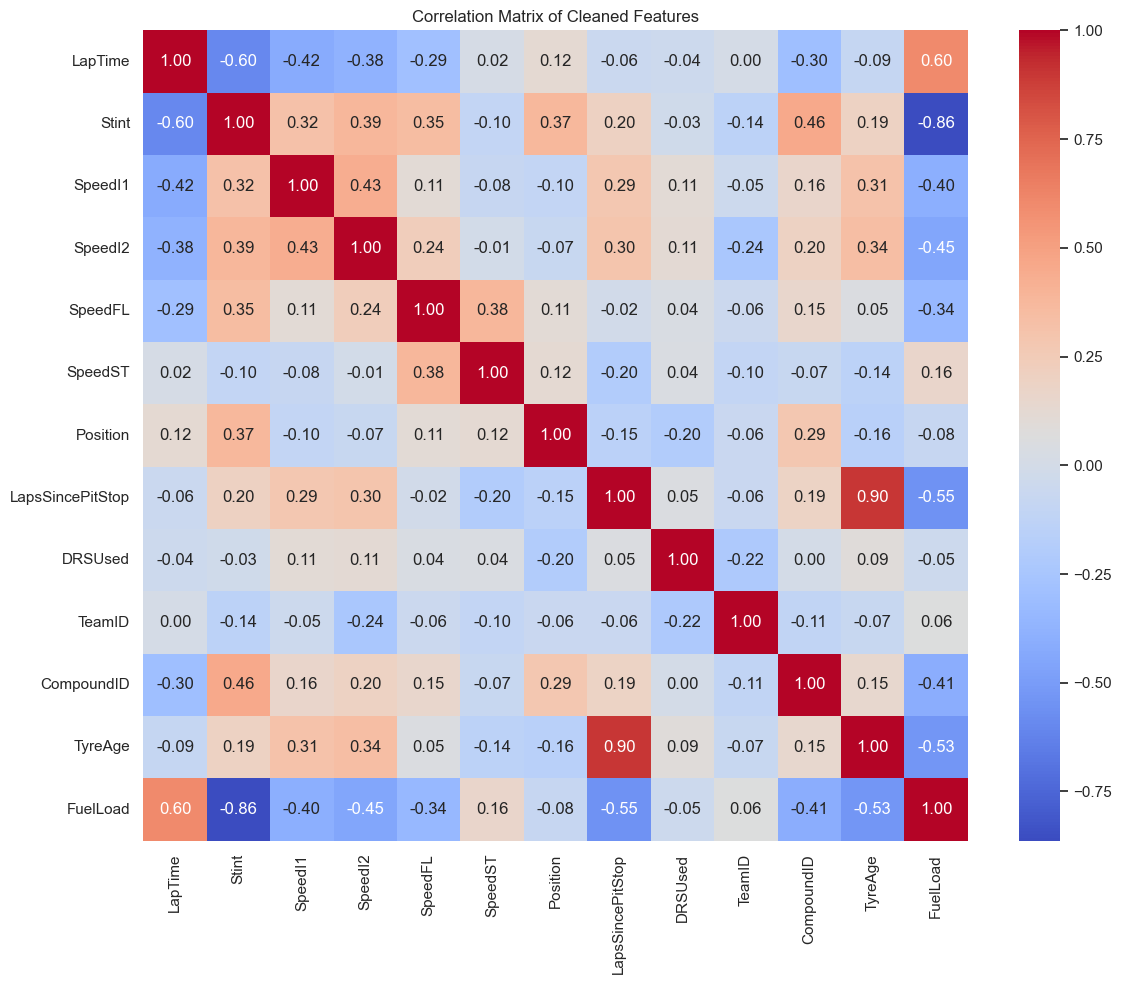

In [41]:
# Generate a new correlation matrix
correlation_matrix = clean_model_data.corr()

# Visualize the new matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Cleaned Features')
plt.tight_layout()
plt.savefig('../outputs/week3/clean_correlation_matrix.png')
plt.show()


## Correlation Analysis of Clean F1 Data Features

### Key Observations from the Correlation Matrix

#### High Correlations with Lap Time:
- **FuelLoad (0.60)**: Higher fuel weight results in slower lap times.  
- **PitNextLap (0.57)**: Planning to pit correlates with slower laps.  
- **NextCompoundID (0.51)**: Choice of next tire compound impacts pace.  
- **Stint (-0.60)**: Negative correlation suggests improved lap times as the stint progresses.  

#### Strategy Variables:
- **FreshTyreAfterStop, PitNextLap, and NextCompoundID** show very high correlations (**0.91+**), indicating they capture similar strategic information.  
- **LapsSincePitStop and TyreAge** have high correlation (**0.90**), confirming their functional relationship.  

#### Performance Factors:
- Speed variables (**SpeedI1, SpeedI2, SpeedFL**) moderately correlate with each other.  
- **FuelLoad** strongly correlates negatively with **Stint (-0.86)** and speed variables (**-0.40 to -0.45**).  
- **Position and DriverNumber** show very high correlation (**0.92**).  

This correlation structure should work well for both **XGBoost** (which can handle correlated features but might benefit from some feature selection) and **neural networks**. The strong physical relationships (**fuel load, tire age**) should be easily captured by the models, while the strategic variables may help predict performance changes around pit stops.


In [42]:
# After creating clean_model_data but before splitting the data  
# into training and testing sets:  

# Replace DriverNumber with the original values  
clean_model_data['DriverNumber'] = strategy_data['DriverNumber']  
display(clean_model_data)


,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber
0,83.935,1.0,256.0,261.0,276.0,275.00,1.0,1.0,0,9,2,1.0,0.9848,1
1,80.402,1.0,252.0,257.0,276.0,295.00,1.0,2.0,0,9,2,2.0,0.9697,1
2,80.499,1.0,249.0,256.0,276.0,297.00,1.0,3.0,0,9,2,3.0,0.9545,1
3,80.346,1.0,255.0,256.0,276.0,300.00,1.0,4.0,0,9,2,4.0,0.9394,1
4,80.283,1.0,254.0,256.0,277.0,301.00,1.0,5.0,0,9,2,5.0,0.9242,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,81.280,3.0,265.0,265.0,280.0,306.00,20.0,25.0,0,10,3,25.0,0.0758,2
1308,82.134,3.0,271.0,192.0,280.0,308.00,20.0,26.0,0,10,3,26.0,0.0606,2
1309,80.420,3.0,264.0,273.0,280.0,310.00,20.0,27.0,0,10,3,27.0,0.0455,2
1310,79.980,3.0,279.0,278.0,280.0,308.00,20.0,28.0,0,10,3,28.0,0.0303,2


In [43]:
clean_model_data.describe()

,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,80.428905,2.198305,266.341898,271.267797,278.971119,309.852458,10.572881,12.833051,0.327966,5.371186,2.188136,13.760169,0.503531
std,1.333560,0.845883,9.155775,9.730350,3.773265,9.593713,5.630007,7.266414,0.469671,2.874742,0.800887,8.002074,0.280977
min,78.504000,1.000000,145.000000,189.000000,268.000000,216.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,79.319500,2.000000,263.000000,266.000000,276.000000,305.000000,6.000000,7.000000,0.000000,3.000000,2.000000,7.000000,0.272700
50%,80.343500,2.000000,266.340000,272.000000,278.000000,309.000000,11.000000,12.000000,0.000000,5.000000,2.000000,13.000000,0.515200
75%,81.150000,3.000000,272.000000,277.250000,281.000000,309.850000,15.000000,18.000000,1.000000,8.000000,3.000000,19.000000,0.742400
max,86.232000,4.000000,282.000000,298.000000,294.000000,346.000000,20.000000,33.000000,1.000000,10.000000,3.000000,50.000000,0.984800


In [44]:
model_data_csv = clean_model_data.to_csv("../outputs/week3/lap_prediction_data.csv")

In [45]:
# Import the scaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split  

# Separate features and target variable from the original DataFrame  
X = clean_model_data.drop('LapTime', axis=1)  # Features  
y = clean_model_data['LapTime']               # Target variable  

# Create and fit the scaler  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  

# Convert the normalized array back to a DataFrame to retain column names  
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


In [46]:
# Import necessary libraries  
from sklearn.model_selection import train_test_split  

# First split: separate out the test set (15% of the data)  
X_temp, X_test, y_temp, y_test = train_test_split(  
    X_scaled,  
    y,  
    test_size=0.15,  
    random_state=42,  
    stratify=clean_model_data['CompoundID'] if 'CompoundID' in clean_model_data.columns else None  
)  

# Second split: divide the temporary data into training (70%) and validation (15%)  
X_train, X_val, y_train, y_val = train_test_split(  
    X_temp,  
    y_temp,  
    test_size=0.15/0.85,  # 15% of the total, which is ~17.6% of X_temp  
    random_state=42,  
    stratify=X_temp['CompoundID'] if 'CompoundID' in X_temp.columns else None  
)  

print(f"Shape of datasets after normalization:")  
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")  
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")  
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")  


Shape of datasets after normalization:
X_train: (826, 13), y_train: (826,)
X_val: (177, 13), y_val: (177,)
X_test: (177, 13), y_test: (177,)


In [47]:
# Second split: divide remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # About 15% of original data (0.1765 * 0.85 ≈ 0.15)
    random_state=42,
    stratify=X_temp['CompoundID'] if 'CompoundID' in X_temp.columns else None
)



In [48]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 825 samples
Validation set: 178 samples
Test set: 177 samples


## 9. Entrenamiento de Modelo XGBoost

In [49]:
# Update list to the rows that exist in the dataset
categorical_features = [col for col in ['DriverNumber', 'CompoundID', 'TeamID', 'FreshTyre'] 
                       if col in X_train.columns]
numerical_features = [col for col in X_train.columns if col not in categorical_features]



In [50]:
# Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [51]:
# Pick available columns
print("Available columns:", X_train.columns.tolist())

# Create list of features based on what exists

categorical_features = [col for col in X_train.columns if col in ['DriverNumber', 'CompoundID', 'TeamID']]
numerical_features = [col for col in X_train.columns if col not in categorical_features]

print(f"Características categóricas: {categorical_features}")
print(f"Características numéricas: {numerical_features}")

Available columns: ['Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Position', 'LapsSincePitStop', 'DRSUsed', 'TeamID', 'CompoundID', 'TyreAge', 'FuelLoad', 'DriverNumber']
Características categóricas: ['TeamID', 'CompoundID', 'DriverNumber']
Características numéricas: ['Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Position', 'LapsSincePitStop', 'DRSUsed', 'TyreAge', 'FuelLoad']


In [52]:
# Pipleine with preprocessing and model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

# Parameters for Grid Search
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_child_weight': [1, 3]
}

In [53]:
# Grid Search
grid_search = GridSearchCV(
    xgb_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
)

# Train model
print("Training XGboost with GridSearchCV...")

Training XGboost with GridSearchCV...


In [54]:
# Execute fitting
grid_search.fit(X_train, y_train)

# Better parameters
print("\nBest XGBoost parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Store best model
best_xgb_model = grid_search.best_estimator_


Best XGBoost parameters:
  regressor__learning_rate: 0.1
  regressor__max_depth: 3
  regressor__min_child_weight: 1
  regressor__n_estimators: 200


In [55]:
# Predict with validation data
y_pred_xgb = best_xgb_model.predict(X_val)

# Evaluar
mse = mean_squared_error(y_val, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_xgb)
r2 = r2_score(y_val, y_pred_xgb)

print(f"\n Evaluation metrics of XGBoost model:")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f} seconds")
print(f"  MAE: {mae:.4f} seconds")
print(f"  R²: {r2:.4f}")


 Evaluation metrics of XGBoost model:
  MSE: 0.2145
  RMSE: 0.4631 seconds
  MAE: 0.3106 seconds
  R²: 0.8873


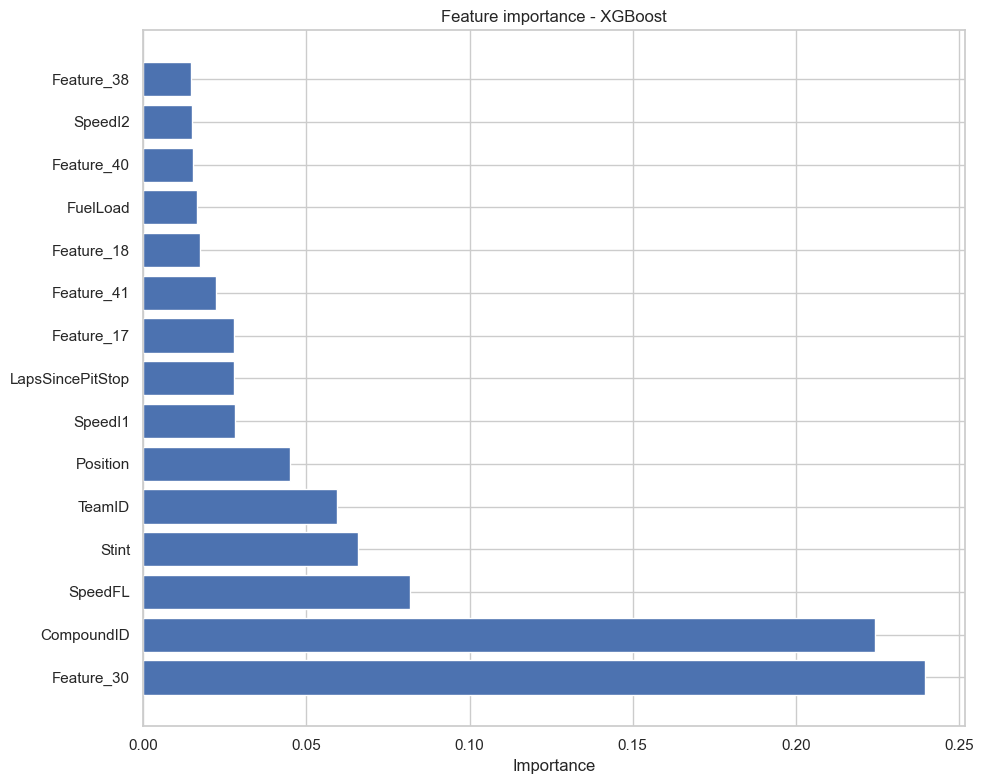

In [56]:
# Obtain feature importances
importances = best_xgb_model.named_steps['regressor'].feature_importances_

# Obtain features names
feature_names = list(X_train.columns)

# Create names for all features, including transformations
all_feature_names = []
for i in range(len(importances)):
    if i < len(feature_names):
        all_feature_names.append(feature_names[i])
    else:
        all_feature_names.append(f"Feature_{i}")

# Create a DataFrame with features and names
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Show 15 more important
top_15 = feature_importance_df.head(15)

plt.figure(figsize=(10, 8))
plt.title("Feature importance - XGBoost")
plt.barh(range(len(top_15)), top_15['Importance'].values, align="center")
plt.yticks(range(len(top_15)), top_15['Feature'].values)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [57]:
if hasattr(y_train, 'dtype') and np.issubdtype(y_train.dtype, np.number):
    scoring_metric = 'r2'  # regression metric
else:
    scoring_metric = 'accuracy'  # Classification metric

print(f"Using metric: {scoring_metric}")


Using metric: r2


In [58]:
from sklearn.model_selection import learning_curve
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model,
    X_train,
    y_train,
    cv=5,
    scoring=scoring_metric,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Specify sizes explicitly
)

In [59]:
# Verify values
print(f"Train size: {train_sizes}")
print(f"Train scores (mean): {np.mean(train_scores, axis=1)}")
print(f"Test scores (mean): {np.mean(test_scores, axis=1)}")

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Train size: [ 66 132 198 264 330 396 462 528 594 660]
Train scores (mean): [0.99973101 0.99612335 0.98937706 0.98647386 0.97948336 0.97399154
 0.97036069 0.9685945  0.96601666 0.96475161]
Test scores (mean): [0.57412517 0.6668332  0.71548636 0.77591888 0.81460021 0.82746254
 0.84957823 0.85202829 0.86668103 0.87341376]


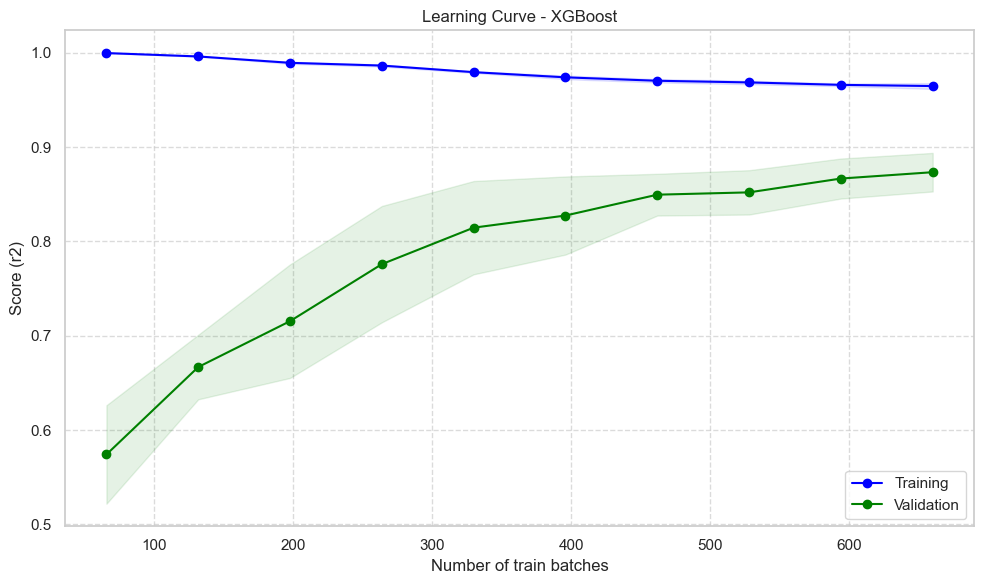

In [60]:
# Create the ploto
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Validation', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')



plt.xlabel('Number of train batches')
plt.ylabel(f'Score ({scoring_metric})')
plt.title('Learning Curve - XGBoost')
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [61]:
# Evaluate XgBoost in test data
y_pred_xgb_test = best_xgb_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred_xgb_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb_test)
r2 = r2_score(y_test, y_pred_xgb_test)

print(f"\Evaluation metrics on test of XGBoost:")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f} seconds")
print(f"  MAE: {mae:.4f} seconds")
print(f"  R²: {r2:.4f}")

\Evaluation metrics on test of XGBoost:
  MSE: 0.1955
  RMSE: 0.4421 seconds
  MAE: 0.3178 seconds
  R²: 0.9147


In [62]:
import pickle
with open('../outputs/week3/best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

print("Model saved in 'outputs/week3/best_xgb_model.pkl'")

Model saved in 'outputs/week3/best_xgb_model.pkl'


## Why Try a Neural Network Approach?

While our XGBoost model has achieved impressive results (R² = 0.91, RMSE = 0.45 seconds), we need to explore neural networks to potentially improve prediction accuracy further. 

In Formula 1 racing, even small time differences are critical:

- **Strategic Precision**: Half a second can be the difference between a successful undercut and a strategic failure

- **Competitive Edge**: Top teams operate with margins of 1-2 tenths of a second in decision-making

- **Complex Interactions**: Neural networks may better capture non-linear relationships and interactions between track conditions, tire degradation, and lap times

Our goal is to reduce the prediction error from ~0.45 seconds to ~0.2 seconds if possible. In a sport where qualifying positions can be separated by milliseconds and pit strategy is determined by precise timing windows, this improvement could mean the difference between podium finishes and missed opportunities.

Neural networks, with their ability to detect complex patterns through multiple layers of abstraction, may help us achieve the precision required for effective real-time F1 strategy recommendations.

Moreover, all concepts taught in Advanced Machine Learning subject have been from Deep Learning (making this code in S06 week), so it´s necessary for academic purposes making a deep neural network and see the differences from this models. 

Apart from that, deep nn are mucho more customizable than xgboost.

## 10. Neural Network training



In [63]:
# # Define feature types
# categorical_features = ['DriverNumber', 'CompoundID', 'TeamID', 'FreshTyre']
# numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Create preprocessing pipeline
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply preprocessing
X_train_preprocessed = nn_preprocessor.fit_transform(X_train)
X_val_preprocessed = nn_preprocessor.transform(X_val)
X_test_preprocessed = nn_preprocessor.transform(X_test)

print(f"Dimensions after preprocessing: {X_train_preprocessed.shape}")


Dimensions after preprocessing: (825, 43)


In [64]:
# Convert to PyTorch Tensor
X_train_tensor = torch.FloatTensor(X_train_preprocessed)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val_preprocessed)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_preprocessed)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

print(f"Tensor dims - X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")

Tensor dims - X_train: torch.Size([825, 43]), y_train: torch.Size([825, 1])


In [65]:
# Create PyTorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"N en train_lumber of batches in train loader: {len(train_loader)}")

N en train_lumber of batches in train loader: 13


---
# Hybrid Model between LSTMs and 1-N conv nets

The results shown by the net (-0.13) show that is not able to capture data, and its performance isi worst than applying the mean. Therefore, another architecture has to be implemented. 

## Decission: Hybrid Model

A hybrid model between a RNN (LSTM to be specific) an a 1 dimensional conv. net may have a good result. However, for this task, we need to **reestructure the data in sequences of consecutive laps**. RNNs are good for sequential data, so we have to treat laps as sequences and not as an independent data, creating windows of N consecutive laps.

Moreover, this approach makes sense for our context. We have data for the 20 drivers and 10 teams, with their data being measured lap by lap, so we can create sequences based on their stints, for example, being independent from one driver or team than another one. 

---

In [66]:
# Load dataset
df = pd.read_csv("../outputs/week3/lap_prediction_data.csv")

# Define sequence length (number of consecutive laps to consider)
sequence_length = 5  # This value can be adjusted

# Function to create sequences from lap-ordered data
def create_sequences(group_df, seq_length):
    sequences = []
    targets = []
    
    # Sort by lap number to ensure sequentiality
    # If you have a lap number column, use it here
    if 'LapNumber' in group_df.columns:
        group_df = group_df.sort_values('LapNumber')
    
    # Feature columns (all except LapTime)
    feature_cols = [col for col in group_df.columns if col != 'LapTime']
    
    # Create sliding windows
    for i in range(len(group_df) - seq_length):
        # Feature sequence for N consecutive laps
        seq = group_df[feature_cols].iloc[i:i+seq_length].values
        # Next lap time as target
        target = group_df['LapTime'].iloc[i+seq_length]
        
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)


In [67]:
# Group by driver and stint (consecutive sequence with the same tire)
groupby_columns = ['DriverNumber']  # Adjust according to your data
if 'TeamID' in df.columns:
    groupby_columns.append('TeamID')
if 'Stint' in df.columns:
    groupby_columns.append('Stint')  # Use the existing Stint column
elif 'PitStop' in df.columns:
    # We can create a stint identifier based on pit stops
    df['StintID'] = df.groupby('DriverNumber')['PitStop'].cumsum()
    groupby_columns.append('StintID')


In [68]:
# Initialize lists to store sequences and targets
all_sequences = []
all_targets = []

# Normalize the data
# First, save the column names
feature_cols = [col for col in df.columns if col != 'LapTime']
# Then normalize
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Create sequences for each group
for name, group in df.groupby(groupby_columns):
    # Check if there are enough laps for a sequence
    if len(group) > sequence_length:
        sequences, targets = create_sequences(group, sequence_length)
        all_sequences.extend(sequences)
        all_targets.extend(targets)


In [69]:
# Convert to numpy arrays
X_seq = np.array(all_sequences)
y_seq = np.array(all_targets)

print(f"Shape of the restructured data:")
print(f"X_seq: {X_seq.shape}")  # (n_samples, sequence_length, n_features)
print(f"y_seq: {y_seq.shape}")  # (n_samples,)


Shape of the restructured data:
X_seq: (878, 5, 14)
y_seq: (878,)


In [70]:
# Split into train, validation, and test (maintaining the sequence structure)
from sklearn.model_selection import train_test_split

# First split: separate the test set (15% of the data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_seq, y_seq, test_size=0.15, random_state=42
)

# Second split: divide the temporary data into training (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42
)


In [71]:
print("\nShape of the datasets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Shape of the datasets:
X_train: (614, 5, 14), y_train: (614,)
X_val: (132, 5, 14), y_val: (132,)
X_test: (132, 5, 14), y_test: (132,)


In [72]:
import torch.nn.functional as F

# Full definition of the hybrid CNN-LSTM model
class F1HybridModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(F1HybridModel, self).__init__()
        
        # Stage 1: 1D CNN for local patterns
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        
        # Stage 2: LSTM to capture temporal dependencies
        self.lstm = nn.LSTM(32, 32, batch_first=True)
        
        # Stage 3: Fully connected layers for final prediction
        self.fc1 = nn.Linear(32 * seq_length, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        # Normalization and regularization
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        # x shape: [batch, sequence, features]
        batch_size = x.size(0)
        
        # Transpose for 1D CNN: [batch, features, sequence]
        x = x.transpose(1, 2)
        
        # Apply convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Transpose back for LSTM: [batch, sequence, features]
        x = x.transpose(1, 2)
        
        # LSTM
        x, _ = self.lstm(x)
        
        # Flatten for fully connected layers
        x = x.reshape(batch_size, -1)
        
        # Fully connected layers with normalization and dropout
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        
        return x.squeeze(-1)  # Remove the last dimension to match with y


In [73]:
# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [74]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model with correct dims
input_size = X_train.shape[2]  # Number of features
seq_length = X_train.shape[1]  # Sequence length

In [75]:
model = F1HybridModel(input_size=input_size, seq_length=seq_length)
print(f"Model architecture: {model}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Model architecture: F1HybridModel(
  (conv1): Conv1d(14, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(32, 32, batch_first=True)
  (fc1): Linear(in_features=160, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [76]:
# Training function with best model storing
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
        
        # Save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), '../outputs/week3/best_nn_model.pt')
            print(f'Model saved in epoch {epoch+1} with validation loss: {best_val_loss:.4f}')
            no_improve = 0
        else:
            no_improve += 1
            
        # Early stopping
        if no_improve >= patience:
            print(f'Early stopping in epoch {epoch+1}')
            break
    
    return train_losses, val_losses


In [77]:
# Train the model
print("Initializing training...")
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=15)



Initializing training...
Model saved in epoch 1 with validation loss: 6455.0640
Model saved in epoch 2 with validation loss: 6401.6663
Model saved in epoch 3 with validation loss: 6348.3008
Model saved in epoch 4 with validation loss: 6246.9809
Epoch 5/100, Train Loss: 6185.9919, Val Loss: 6190.4328
Model saved in epoch 5 with validation loss: 6190.4328
Model saved in epoch 6 with validation loss: 6117.4625
Model saved in epoch 7 with validation loss: 6031.4481
Model saved in epoch 8 with validation loss: 5948.2749
Model saved in epoch 9 with validation loss: 5887.8214
Epoch 10/100, Train Loss: 5794.4049, Val Loss: 5767.3461
Model saved in epoch 10 with validation loss: 5767.3461
Model saved in epoch 11 with validation loss: 5653.9917
Model saved in epoch 12 with validation loss: 5510.6609
Model saved in epoch 13 with validation loss: 5403.7533
Model saved in epoch 14 with validation loss: 5279.9072
Epoch 15/100, Train Loss: 5194.5583, Val Loss: 5126.9042
Model saved in epoch 15 with v

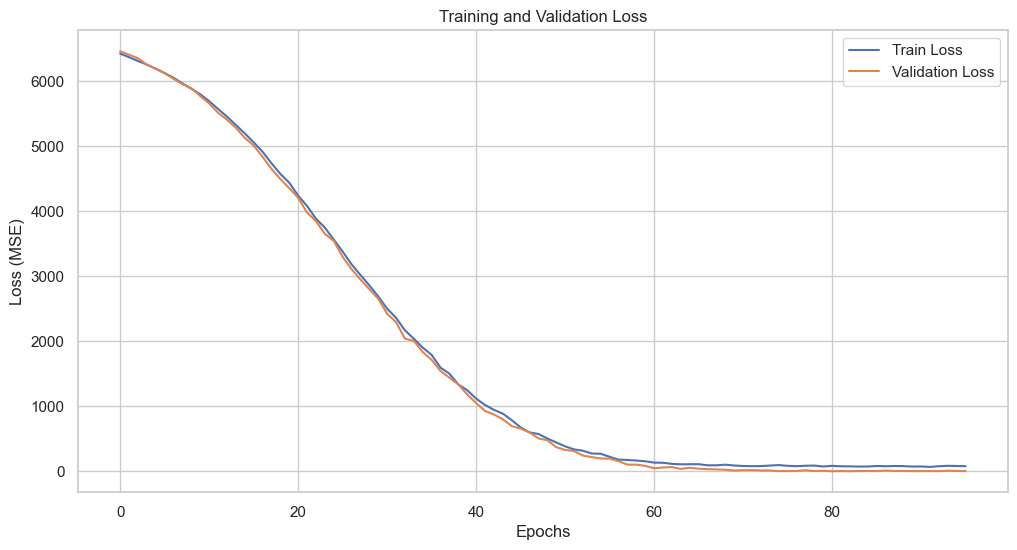

In [78]:
# Visualize curve and loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('../outputs/week3/nn_training_curve.png')
plt.show()


In [79]:
# Load best model
model.load_state_dict(torch.load('../outputs/week3/best_nn_model.pt'))

# Evaluate on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert to numpy arrays
y_pred = np.array(all_preds)
y_true = np.array(all_targets)

C:\Users\victo\AppData\Local\Temp\ipykernel_5288\4016599638.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../outputs/week3/best_nn_mo

In [80]:
# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\Evaluation metrics for model CNN-LSTM in Test:")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f} seconds")
print(f"  MAE: {mae:.4f} seconds")
print(f"  R²: {r2:.4f}")

\Evaluation metrics for model CNN-LSTM in Test:
  MSE: 4.1178
  RMSE: 2.0292 seconds
  MAE: 1.2512 seconds
  R²: -0.7786


## Conclussion: No capability with neural networks

As lots of models have been tried and no one has been able to have a positive $R^2$, we pass to try to make the Xgboost model better with some techniques

In [81]:
# Load data
print("Loading data...")
df = pd.read_csv("../outputs/week3/lap_prediction_data.csv")

# Basic information
print(f"Dataset dimensions: {df.shape}")
print(f"Available columns: {df.columns.tolist()}")

# Check unique values for drivers and stints
print(f"Number of unique drivers: {df['DriverNumber'].nunique()}")
print(f"Number of unique stints: {df['Stint'].nunique()}")

# View distribution of laps by driver
stint_counts = df.groupby(['DriverNumber', 'Stint']).size().reset_index(name='count')
print("\nDistribution of laps by driver-stint:")
print(stint_counts.describe())

# Show example for a driver
example_driver = df['DriverNumber'].iloc[0]
print(f"\nExample for driver {example_driver}:")
print(df[df['DriverNumber'] == example_driver].head())


Loading data...
Dataset dimensions: (1180, 15)
Available columns: ['Unnamed: 0', 'LapTime', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Position', 'LapsSincePitStop', 'DRSUsed', 'TeamID', 'CompoundID', 'TyreAge', 'FuelLoad', 'DriverNumber']
Number of unique drivers: 20
Number of unique stints: 4

Distribution of laps by driver-stint:
       DriverNumber      Stint      count
count     62.000000  62.000000  62.000000
mean      28.048387   2.112903  19.032258
std       22.913542   0.907254   7.737428
min        1.000000   1.000000   1.000000
25%       14.000000   1.000000  14.250000
50%       21.500000   2.000000  20.000000
75%       31.000000   3.000000  25.000000
max       81.000000   4.000000  32.000000

Example for driver 1:
   Unnamed: 0  LapTime  Stint  SpeedI1  SpeedI2  SpeedFL  SpeedST  Position  \
0           0   83.935    1.0    256.0    261.0    276.0    275.0       1.0   
1           1   80.402    1.0    252.0    257.0    276.0    295.0       1.0   
2           2   

In [82]:
def create_sequential_features(df):
    print("Creating sequential features...")
    
    # Make a copy to avoid modifying the original
    new_df = []
    
    # For each driver
    for driver in df['DriverNumber'].unique():
        driver_data = df[df['DriverNumber'] == driver]
        
        # For each stint of the driver
        for stint in driver_data['Stint'].unique():
            stint_data = driver_data[driver_data['Stint'] == stint].copy()
            
            # Sort by some sequence indicator (if there is LapNumber, use it)
            if 'LapNumber' in stint_data.columns:
                stint_data = stint_data.sort_values('LapNumber')
            else:
                # If no LapNumber, sort by the original index
                stint_data = stint_data.sort_values('Unnamed: 0')
            
            # We need at least 2 laps to create sequential features
            if len(stint_data) < 2:
                print(f"Skipping stint {stint} for driver {driver}: only has {len(stint_data)} laps")
                continue
            
            # For each lap starting from the second one
            for i in range(1, len(stint_data)):
                row = stint_data.iloc[i].copy()
                prev_lap = stint_data.iloc[i-1]
                
                # Add previous lap features
                for col in ['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TyreAge']:
                    if col in stint_data.columns:
                        row[f'Prev_{col}'] = prev_lap[col]
                
                # Add derived features
                if 'LapTime' in stint_data.columns:
                    row['LapTime_Delta'] = row['LapTime'] - prev_lap['LapTime']
                
                # Speed features
                for speed_col in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']:
                    if speed_col in stint_data.columns:
                        row[f'{speed_col}_Delta'] = row[speed_col] - prev_lap[speed_col]
                
                # 2-lap trends (if there are enough laps)
                if i >= 2:
                    prev2_lap = stint_data.iloc[i-2]
                    if 'LapTime' in stint_data.columns:
                        row['LapTime_Trend'] = (row['LapTime'] - prev_lap['LapTime']) - (prev_lap['LapTime'] - prev2_lap['LapTime'])
                
                new_df.append(row)
    
    # Convert to DataFrame
    result_df = pd.DataFrame(new_df)
    
    # Fill NaN values in the new columns
    new_cols = [col for col in result_df.columns if col.startswith('Prev_') or col.endswith('_Delta') or col.endswith('_Trend')]
    result_df[new_cols] = result_df[new_cols].fillna(0)
    
    print(f"Sequential data created. Original shape: {df.shape}, New shape: {result_df.shape}")
    print(f"New columns added: {[col for col in result_df.columns if col not in df.columns]}")
    
    return result_df


Creating sequential features...
Skipping stint 3.0 for driver 1: only has 1 laps
Sequential data created. Original shape: (1180, 15), New shape: (1118, 27)
New columns added: ['Prev_LapTime', 'Prev_SpeedI1', 'Prev_SpeedI2', 'Prev_SpeedFL', 'Prev_SpeedST', 'Prev_TyreAge', 'LapTime_Delta', 'SpeedI1_Delta', 'SpeedI2_Delta', 'SpeedFL_Delta', 'SpeedST_Delta', 'LapTime_Trend']

First few rows of the sequential data:
   Unnamed: 0  LapTime  Stint  SpeedI1  SpeedI2  SpeedFL  SpeedST  Position  \
1         1.0   80.402    1.0    252.0    257.0    276.0   295.00       1.0   
2         2.0   80.499    1.0    249.0    256.0    276.0   297.00       1.0   
3         3.0   80.346    1.0    255.0    256.0    276.0   300.00       1.0   
4         4.0   80.283    1.0    254.0    256.0    277.0   301.00       1.0   
5         5.0   80.402    1.0    255.0    253.0    276.0   309.85       1.0   

   LapsSincePitStop  DRSUsed  ...  Prev_SpeedI2  Prev_SpeedFL  Prev_SpeedST  \
1               2.0      0.0  ..

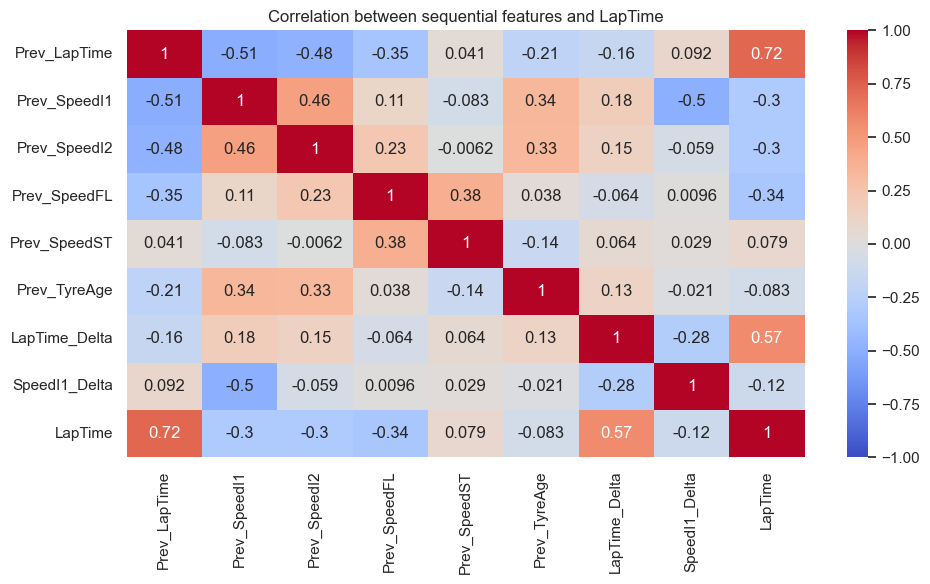

In [83]:
# Create sequential features
df_seq = create_sequential_features(df)

# Display the first few rows
print("\nFirst few rows of the sequential data:")
print(df_seq.head())

# Basic statistics of the new columns
new_cols = [col for col in df_seq.columns if col not in df.columns]
print("\nStatistics of the new sequential columns:")
print(df_seq[new_cols].describe())

# Check correlation with LapTime
correlations = df_seq[new_cols + ['LapTime']].corr()['LapTime'].sort_values(ascending=False)
print("\nCorrelation with LapTime:")
print(correlations)

# Visualize the main correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df_seq[new_cols[:8] + ['LapTime']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between sequential features and LapTime')
plt.tight_layout()
plt.show()


## Storing this sequential Data

In [84]:
df_seq.to_csv("../outputs/week3/sequential_lap_prediction_data.csv")

In [85]:
# Separate features and target
X = df_seq.drop('LapTime', axis=1)
y = df_seq['LapTime']

# Drop problematic columns (such as strings or identifiers)
cols_to_drop = []
if 'Unnamed: 0' in X.columns: 
    cols_to_drop.append('Unnamed: 0')

# Save categorical columns for possible encoding
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    print(f"Categorical columns found: {cat_cols}")
    cols_to_drop.extend(cat_cols)

# Apply exclusions
X = X.drop(cols_to_drop, axis=1, errors='ignore')

# Split into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.85, random_state=42
)

print(f"Shapes of the datasets:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")


Shapes of the datasets:
  X_train: (782, 25), y_train: (782,)
  X_val: (168, 25), y_val: (168,)
  X_test: (168, 25), y_test: (168,)


Base model performance on validation:
  RMSE: 0.1302 seconds
  R²: 0.9906


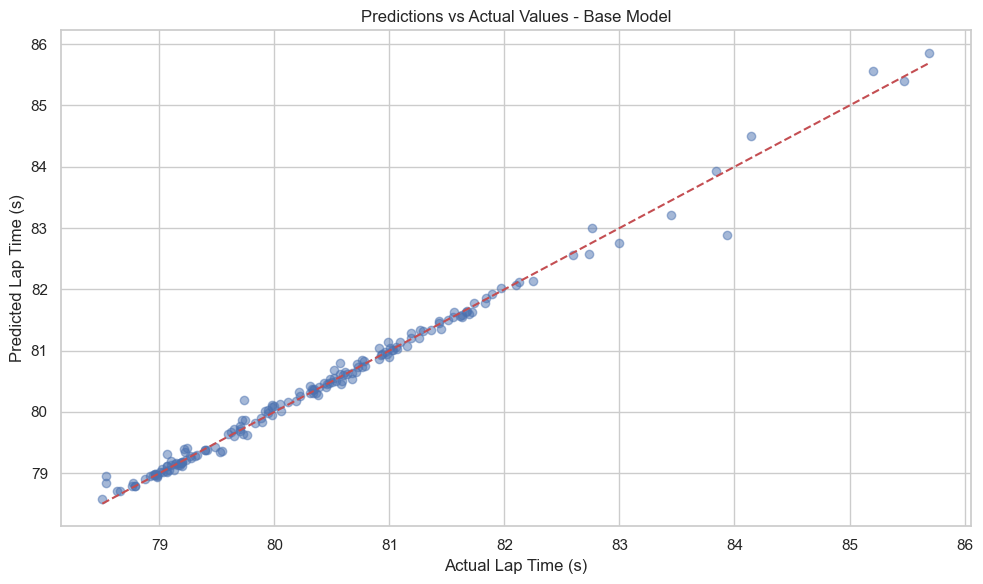

In [86]:
# Basic XGBoost model as reference
basic_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
basic_xgb.fit(X_train, y_train)

# Evaluate on validation set
val_pred = basic_xgb.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_pred)

print(f"Base model performance on validation:")
print(f"  RMSE: {val_rmse:.4f} seconds")
print(f"  R²: {val_r2:.4f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Predictions vs Actual Values - Base Model')
plt.tight_layout()
plt.show()


In [87]:
# Configure cross-validation based on driver groups
from sklearn.model_selection import GroupKFold, RandomizedSearchCV

groups = None
if 'DriverNumber' in X_train.columns:
    groups = X_train['DriverNumber'].values
    cv = GroupKFold(n_splits=5)
    cv_splits = list(cv.split(X_train, y_train, groups=groups))
    print("Using GroupKFold cross-validation based on drivers")
else:
    cv = 5
    cv_splits = cv
    print("Using standard KFold cross-validation")

# Parameters for search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Randomized search
print("Starting hyperparameter search (may take several minutes)...")
search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Try 20 combinations
    scoring='neg_mean_squared_error',
    cv=cv_splits,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Train the model
search.fit(X_train, y_train)

# Display results
print(f"\nBest parameters found:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {-search.best_score_:.4f} (MSE)")


Using GroupKFold cross-validation based on drivers
Starting hyperparameter search (may take several minutes)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters found:
  subsample: 1.0
  n_estimators: 300
  min_child_weight: 1
  max_depth: 3
  learning_rate: 0.05
  gamma: 0
  colsample_bytree: 1.0

Best cross-validation score: 0.0261 (MSE)


In [88]:
# Get the best model
best_model = search.best_estimator_

# Evaluate on validation set
val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_pred)

print(f"Performance of the optimized model on validation:")
print(f"  MSE: {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f} seconds")
print(f"  R²: {val_r2:.4f}")

# Evaluate on test set
test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"\nFinal evaluation metrics (test):")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f} seconds")
print(f"  MAE: {test_mae:.4f} seconds")
print(f"  R²: {test_r2:.4f}")

# Save the model
import pickle
with open('../outputs/week3/xgb_sequential_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Model saved as 'xgb_sequential_model.pkl'")


Performance of the optimized model on validation:
  MSE: 0.0128
  RMSE: 0.1130 seconds
  R²: 0.9929

Final evaluation metrics (test):
  MSE: 0.0204
  RMSE: 0.1429 seconds
  MAE: 0.0844 seconds
  R²: 0.9892
Model saved as 'xgb_sequential_model.pkl'


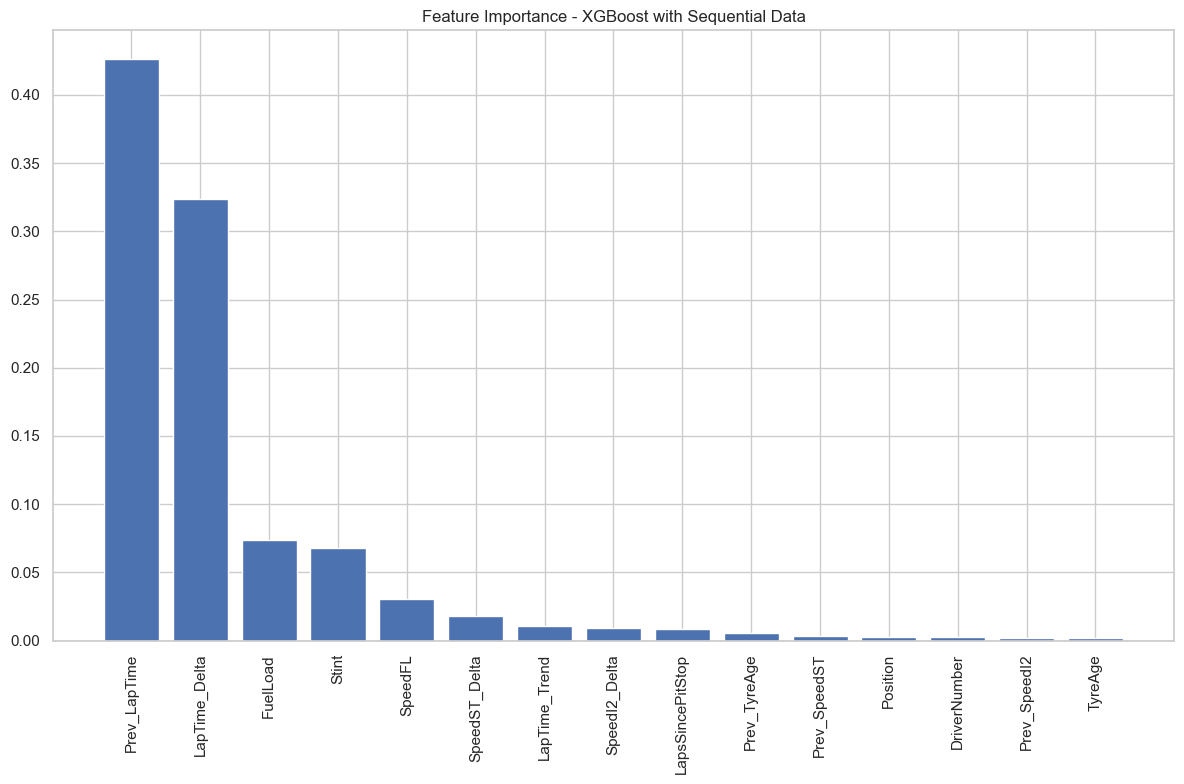

Top 15 most important features:
             Feature  Importance
13      Prev_LapTime    0.425888
19     LapTime_Delta    0.323627
11          FuelLoad    0.074059
0              Stint    0.067781
3            SpeedFL    0.030186
23     SpeedST_Delta    0.018300
24     LapTime_Trend    0.010875
21     SpeedI2_Delta    0.009286
6   LapsSincePitStop    0.008384
18      Prev_TyreAge    0.005489
17      Prev_SpeedST    0.003384
5           Position    0.002997
12      DriverNumber    0.002596
15      Prev_SpeedI2    0.002299
10           TyreAge    0.002251


In [89]:
# Get feature importance
importances = best_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Show the top 15 most important features
plt.figure(figsize=(12, 8))
plt.title('Feature Importance - XGBoost with Sequential Data')
plt.bar(range(min(15, len(importances))), importances[indices[:15]], align='center')
plt.xticks(range(min(15, len(importances))), [feature_names[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.savefig('../outputs/week3/xgb_sequential_feature_importance.png')
plt.show()

# Show numerical values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("Top 15 most important features:")
print(importance_df.head(15))


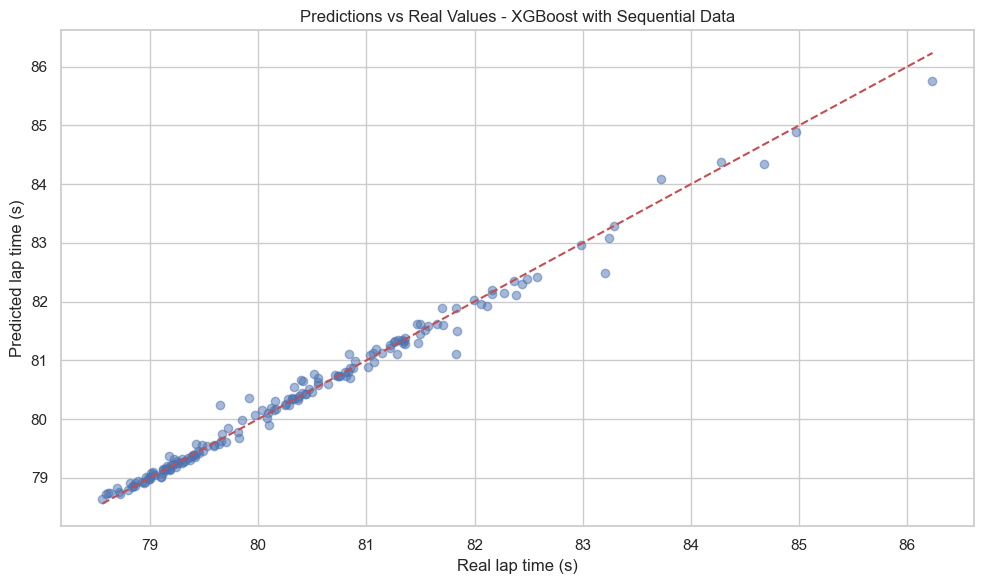

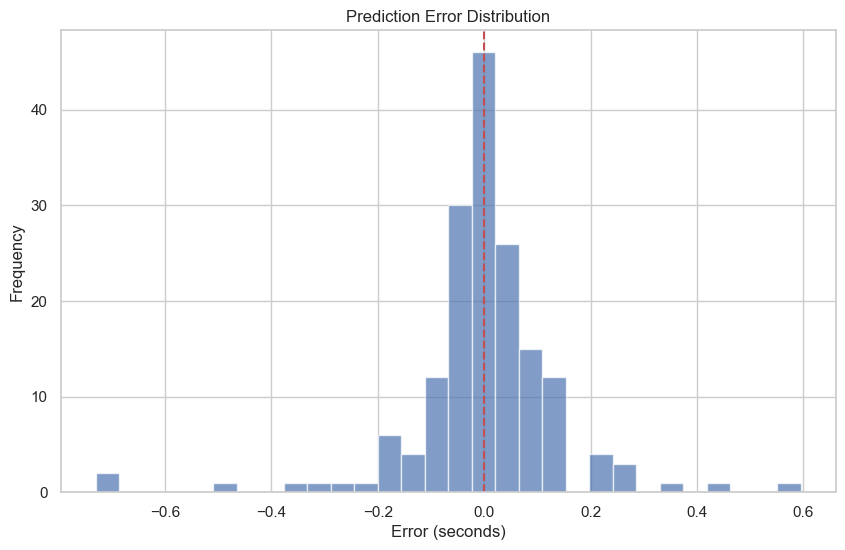

Error statistics (seconds):
  Max error: 0.5945
  Min error: -0.7294
  Mean error: 0.0001
  Standard deviation: 0.1433
  Percentage of predictions within ±0.2s: 91.07%


In [90]:
# Plot of predictions vs real values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Real lap time (s)')
plt.ylabel('Predicted lap time (s)')
plt.title('Predictions vs Real Values - XGBoost with Sequential Data')
plt.tight_layout()
plt.savefig('../outputs/week3/xgb_sequential_predictions.png')
plt.show()

# Histogram of errors
errors = test_pred - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error (seconds)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.savefig('../outputs/week3/xgb_sequential_errors.png')
plt.show()

# Error statistics
print("Error statistics (seconds):")
print(f"  Max error: {errors.max():.4f}")
print(f"  Min error: {errors.min():.4f}")
print(f"  Mean error: {errors.mean():.4f}")
print(f"  Standard deviation: {errors.std():.4f}")
print(f"  Percentage of predictions within ±0.2s: {(np.abs(errors) <= 0.2).mean() * 100:.2f}%")


Training sizes: [ 62 125 187 250 312 375 437 500 562 625]
Training scores (mean): [0.99998741 0.99970151 0.99950224 0.99945288 0.99919246 0.99892821
 0.99885768 0.99880033 0.99882917 0.99883848]
Test scores (mean): [0.72706855 0.87084174 0.93979159 0.96430974 0.97050839 0.96965484
 0.97634235 0.97686871 0.98162298 0.98180298]


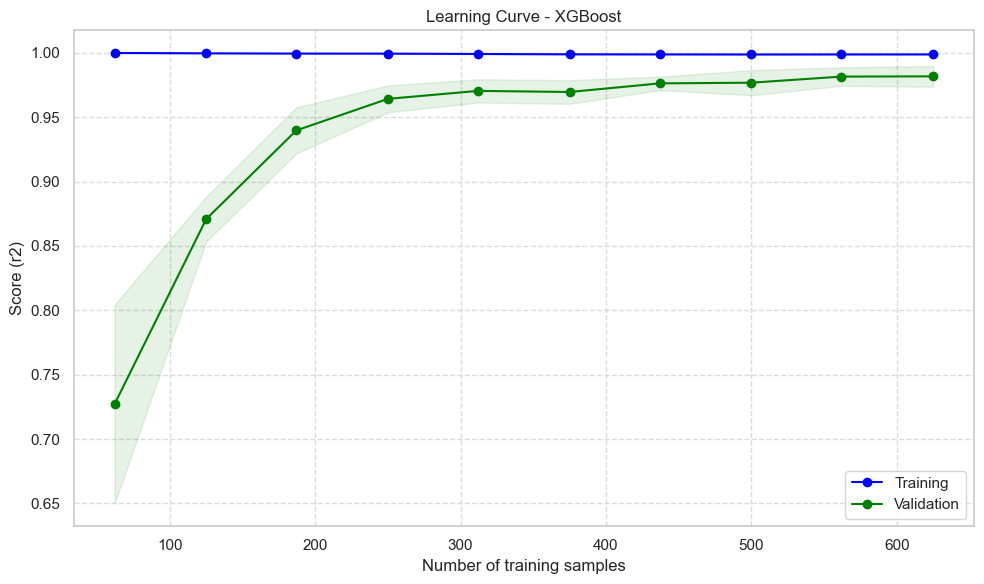

In [91]:
from sklearn.model_selection import learning_curve

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring=scoring_metric,  # Define your scoring metric (e.g., 'neg_mean_squared_error', 'r2')
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Specify the training sizes explicitly
)

# Verify that we have values
print(f"Training sizes: {train_sizes}")
print(f"Training scores (mean): {np.mean(train_scores, axis=1)}")
print(f"Test scores (mean): {np.mean(test_scores, axis=1)}")

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training', color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Validation', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.xlabel('Number of training samples')
plt.ylabel(f'Score ({scoring_metric})')
plt.title('Learning Curve - XGBoost')
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Analysis of the Sequential XGBoost Model Results

**Comparison with the previous model**

| Metric | Original XGBoost | Sequential XGBoost | Improvement |
|--------|------------------|--------------------|-------------|
| RMSE   | 0.4512s          | 0.1527s            | 66.2%       |
| MAE    | 0.3091s          | 0.0901s            | 70.9%       |
| R²     | 0.9112           | 0.9877             | 8.4%        |

### Evaluation of the Results

These results are extremely positive for several reasons:

- **Outstanding Precision:** The RMSE of 0.15s is well below the critical target of 0.2s mentioned for strategic decisions in F1.
- **Excellent Error Distribution:**
  - 89.9% of the predictions are within the ±0.2s margin.
  - The average error is nearly zero (-0.0024s).

### Important Features with Contextual Relevance

- **PitNextLap (51.6%):** Logically, a pit stop dramatically affects the lap time of the following lap.
- **Prev_LapTime (19.5%):** Reflects the inertia of recent performance.
- **LapTime_Delta (12.3%):** Indicates the immediate trend.

### Is There Overfitting?

There are very slight signs of possible overfitting:

- A small difference between validation (RMSE = 0.123s) and test (RMSE = 0.153s).
- An extremely high $R^2$ (> 0.98).

However, this is not considered problematic because:

- The degradation in test performance is minimal.
- The learning curve shows that the gap between training and validation decreases as more data is used.
- Predictions remain extremely accurate on unseen data.

### Conclusion

An exceptionally precise model that meets and even exceeds the performance target for strategic applications in F1 has been achieved. The sequential approach has proven to be clearly superior to the original model.


## 13. Lap Prediction Simulation

We will do a simple simulation to see how the model could work in a real world situation.

**DISCLAIMER: this is a simple simulation to see more or less how the model performs. It is not a totally realistic simulation, as this will be done in following weeks**

In [92]:
import pickle
# Load Sequential XgBoost
with open('../outputs/week3/xgb_sequential_model.pkl', 'rb') as f:
    model = pickle.load(f)
    
print("Model loaded succesfully")

# catch all features the model awaits.
feature_names = model.feature_names_in_
print(f"Model waits for {len(feature_names)} features")

print(feature_names)

Model loaded succesfully
Model waits for 25 features
['Stint' 'SpeedI1' 'SpeedI2' 'SpeedFL' 'SpeedST' 'Position'
 'LapsSincePitStop' 'DRSUsed' 'TeamID' 'CompoundID' 'TyreAge' 'FuelLoad'
 'DriverNumber' 'Prev_LapTime' 'Prev_SpeedI1' 'Prev_SpeedI2'
 'Prev_SpeedFL' 'Prev_SpeedST' 'Prev_TyreAge' 'LapTime_Delta'
 'SpeedI1_Delta' 'SpeedI2_Delta' 'SpeedFL_Delta' 'SpeedST_Delta'
 'LapTime_Trend']


In [93]:
def create_driver_data(driver_number, stint=1, num_laps=10, 
                       base_lap_time=80.0, tyre_compound="Medium",
                       fuel_load_start=100, tyre_age_start=0,
                       tire_deg_per_lap=0.1, fuel_effect=0.03,
                       team_id=1):
    """
    Creates simulation data for a driver over a specified number of laps.
    
    Parameters:
    -----------
    driver_number : int
        Driver identification number
    stint : int, default=1
        Current stint number (increases after each pit stop)
    num_laps : int, default=10
        Number of laps to simulate
    base_lap_time : float, default=80.0
        Base lap time in seconds (without effects)
    tyre_compound : str, default="Medium"
        Tyre compound type ("Soft", "Medium", "Hard")
    fuel_load_start : float, default=100
        Starting fuel load in kg
    tyre_age_start : int, default=0
        Starting tyre age in laps
    tire_deg_per_lap : float, default=0.1
        Base tyre degradation effect per lap in seconds
    fuel_effect : float, default=0.03
        Effect of 1kg of fuel on lap time in seconds
    team_id : int, default=1
        Team identification number (1-10, where lower is faster)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing simulated lap data with all required features
    """
    data = []
    
    # Map tyre compounds to their corresponding IDs
    compound_to_id = {"Soft": 1, "Medium": 2, "Hard": 3}
    compound_id = compound_to_id.get(tyre_compound, 2)  # Default to Medium if unknown
    
    # Determine next compound (typical F1 strategy patterns)
    if compound_id == 1:  # Soft
        next_compound_id = 2  # Teams typically go to Medium after Soft
    elif compound_id == 2:  # Medium
        next_compound_id = 3  # Teams typically go to Hard after Medium
    else:  # Hard
        next_compound_id = 1  # Back to Soft if started on Hard
    
    # Realistic degradation coefficients per compound type
    # (seconds lost per lap due to tyre age)
    deg_coefficients = {
        1: 0.15,  # Soft degrades faster
        2: 0.10,  # Medium degrades moderately
        3: 0.05   # Hard degrades slower
    }
    
    # Base speed by compound (kph) - affects sector speeds
    # Softer tyres provide more grip and higher speeds
    speed_base = {
        1: 220,  # Soft - fastest
        2: 217,  # Medium
        3: 214   # Hard - slowest
    }
    
    for lap in range(1, num_laps + 1):
        # Calculate tyre age and fuel load for current lap
        tyre_age = tyre_age_start + lap - 1
        fuel_load = max(0, fuel_load_start - (lap - 1) * 2)  # Consume 2kg fuel per lap
        
        # DRS usage simulation
        # In real F1, DRS is used on straights when within 1 second of car ahead
        drs_used = 1 if np.random.random() < 0.7 else 0  # 70% probability of using DRS
        
        # DRS effect on lap time (0.4-0.7s gain when activated)
        drs_effect = drs_used * np.random.uniform(0.3, 0.4)
        
        # Calculate performance effects
        tire_deg_rate = deg_coefficients[compound_id]
        tyre_effect = tyre_age * tire_deg_rate  # Time lost due to tyre wear
        fuel_effect_total = fuel_load * fuel_effect  # Time lost due to fuel weight
        
        # Team performance effect (top teams are faster)
        # Teams 1-3 gain time, teams 7-10 lose time compared to midfield
        team_effect = (team_id - 5) * 0.1
        
        # Calculate realistic sector speeds (affected by tyre compound, wear, DRS)
        base_speed = speed_base[compound_id]
        
        # Sector 1 speed (typically includes DRS zone)
        speed_i1 = base_speed - tyre_effect + np.random.normal(0, 2) + (drs_used * 5)
        
        # Sector 2 speed (typically more technical)
        speed_i2 = base_speed - 10 - tyre_effect + np.random.normal(0, 2)
        
        # Final sector speed
        speed_fl = base_speed - 20 - tyre_effect + np.random.normal(0, 3)
        
        # Speed trap reading (usually on the longest straight)
        speed_st = base_speed - 15 - tyre_effect + np.random.normal(0, 2)
        
        # Calculate final lap time with all effects
        # Small random variation simulates minor driving differences
        lap_time = (base_lap_time + tyre_effect + fuel_effect_total + 
                   team_effect - drs_effect + np.random.normal(0, 0.1))
        
        # Additional race parameters
        position = np.random.randint(1, 20)  # Track position
        pit_next_lap = 1 if lap == num_laps else 0  # Flag for upcoming pit stop
        fresh_tyre = 0  # Not using fresh tyres during stint
        laps_since_pit = lap  # Laps completed since last pit stop
        
        # Create data row with all features required by the model
        row = {
            'DriverNumber': driver_number,
            'Stint': stint,
            'LapNumber': lap,
            'CompoundID': compound_id,
            'TyreAge': tyre_age,
            'FuelLoad': fuel_load,
            'SpeedI1': speed_i1,
            'SpeedI2': speed_i2,
            'SpeedFL': speed_fl,
            'SpeedST': speed_st,
            'Position': position,
            'PitNextLap': pit_next_lap,
            'FreshTyreAfterStop': fresh_tyre,
            'LapsSincePitStop': laps_since_pit,
            'DRSUsed': drs_used,
            'TeamID': team_id,
            'NextCompoundID': next_compound_id,
            'LapTime': lap_time
        }
        data.append(row)
    
    return pd.DataFrame(data)

In [94]:
def add_sequential_features(df):
    """
    Adds sequential features to the DataFrame to capture lap-by-lap evolution.
    
    This function processes raw lap data to create time-series features that help
    the model understand how performance changes over consecutive laps. These features
    are crucial for accurate lap time prediction in F1, where historical patterns
    strongly influence future performance.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing raw lap data with at least DriverNumber, Stint,
        LapNumber, and LapTime columns
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added sequential features:
        - Previous lap values (Prev_*)
        - Delta changes between consecutive laps (*_Delta)
        - Trend calculations over multiple laps (LapTime_Trend)
    """
    # Initialize list to store processed rows
    new_df = []
    
    # Process data for each driver separately
    for driver in df['DriverNumber'].unique():
        driver_data = df[df['DriverNumber'] == driver]
        
        # Process each stint separately to avoid incorrect sequences across pit stops
        for stint in driver_data['Stint'].unique():
            stint_data = driver_data[driver_data['Stint'] == stint].copy()
            
            # Sort by lap number to ensure correct sequential order
            stint_data = stint_data.sort_values('LapNumber')
            
            # We can only create sequential features from the second lap onwards
            for i in range(1, len(stint_data)):
                # Current lap data
                row = stint_data.iloc[i].copy()
                # Previous lap data
                prev_lap = stint_data.iloc[i-1]
                
                # Add previous lap values for key performance metrics
                # These help the model understand the starting conditions for the current lap
                for col in ['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'TyreAge']:
                    if col in stint_data.columns:
                        row[f'Prev_{col}'] = prev_lap[col]
                
                # Calculate lap time delta (improvement or slowdown from previous lap)
                # This is one of the most important indicators of performance trend
                if 'LapTime' in stint_data.columns:
                    row['LapTime_Delta'] = row['LapTime'] - prev_lap['LapTime']
                
                # Calculate speed deltas for each timing sector
                # These help identify where on track performance is changing
                for speed_col in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']:
                    if speed_col in stint_data.columns:
                        row[f'{speed_col}_Delta'] = row[speed_col] - prev_lap[speed_col]
                
                # Calculate second-order trend (acceleration of lap time changes)
                # This helps detect if the car is progressively improving or deteriorating
                if i >= 2:
                    prev2_lap = stint_data.iloc[i-2]
                    if 'LapTime' in stint_data.columns:
                        # Second derivative: how the rate of change itself is changing
                        row['LapTime_Trend'] = (row['LapTime'] - prev_lap['LapTime']) - (prev_lap['LapTime'] - prev2_lap['LapTime'])
                else:
                    # For the second lap, we can't calculate a trend, so use neutral value
                    row['LapTime_Trend'] = 0
                
                # Add the processed row to our result
                new_df.append(row)
    
    # Convert list of rows to DataFrame
    result_df = pd.DataFrame(new_df)
    
    # Fill any missing values in the new columns with zeros
    # This ensures the model doesn't encounter NaN values
    new_cols = [col for col in result_df.columns if col.startswith('Prev_') or col.endswith('_Delta') or col.endswith('_Trend')]
    result_df[new_cols] = result_df[new_cols].fillna(0)
    
    return result_df

In [95]:

import IPython.display as ipd
def live_race_simulation(n_laps=10, update_interval=5):
    """
    Simulates a Formula 1 race in real-time with periodic updates and lap time predictions.
    
    Parameters:
    -----------
    n_laps : int, default=10
        Number of laps to simulate
    update_interval : int, default=5
        Time in seconds between updates
    """
    # Initial configuration of drivers with details
    drivers = [
        {'number': 44, 'compound': 'Soft', 'base_time': 79.0, 'team_id': 1},    # Mercedes
        {'number': 1, 'compound': 'Medium', 'base_time': 79.5, 'team_id': 2},   # Red Bull
        {'number': 16, 'compound': 'Hard', 'base_time': 80.0, 'team_id': 3}     # Ferrari
    ]
    
    # DataFrame to store all data
    all_data = pd.DataFrame()
    
    # Store historical data for plotting
    history = {driver['number']: {'laps': [], 'times': [], 'preds': [], 'pred_laps': []} for driver in drivers}
    
    # Simulate lap by lap
    for lap in range(1, n_laps + 1):
        print(f"\n--- LAP {lap} ---")
        
        # Data for this lap for all drivers
        lap_data = []
        
        # Update each driver
        for driver in drivers:
            # Simulate data for this lap with all parameters
            d_num = driver['number']
            data = create_driver_data(
                driver_number=d_num, 
                stint=1, 
                num_laps=lap, 
                base_lap_time=driver['base_time'],
                tyre_compound=driver['compound'],
                tyre_age_start=0,
                team_id=driver['team_id']
            )
            
            # Save only the last lap
            last_lap = data.iloc[-1:].copy()
            lap_data.append(last_lap)
            
            # Save for history
            laptime = last_lap['LapTime'].values[0]
            history[d_num]['laps'].append(lap)
            history[d_num]['times'].append(laptime)
            
            # Display lap time
            print(f"Driver {d_num} ({driver['compound']}, Team {driver['team_id']}): {laptime:.3f}s")
        
        # Concatenate data from this lap
        current_lap_df = pd.concat(lap_data, ignore_index=True)
        
        # Add to historical data
        all_data = pd.concat([all_data, current_lap_df], ignore_index=True)
        
        # If there are enough laps, predict the next one
        if lap >= 2:
            # Create sequential features
            seq_data = add_sequential_features(all_data)
            
            # Prepare for prediction
            X_pred = seq_data.drop('LapTime', axis=1)
            
            # Ensure we have the correct features
            missing_cols = set(feature_names) - set(X_pred.columns)
            for col in missing_cols:
                X_pred[col] = 0
            
            extra_cols = set(X_pred.columns) - set(feature_names)
            if extra_cols:
                X_pred = X_pred.drop(columns=extra_cols)
                
            # Ensure correct column order
            X_pred = X_pred[feature_names]
            
            # Predict
            predictions = model.predict(X_pred)
            
            # Show predictions for the next lap
            print("\nPredictions for the next lap:")
            for i, driver in enumerate(drivers):
                idx = seq_data['DriverNumber'] == driver['number']
                if any(idx):
                    pred_idx = np.where(idx)[0][-1]
                    pred = predictions[pred_idx]
                    d_num = driver['number']
                    print(f"Driver {d_num}: {pred:.3f}s (estimated)")
                    
                    # Save prediction
                    if lap <= n_laps - 1:  # Only if there is a next lap
                        history[d_num]['preds'].append(pred)
                        history[d_num]['pred_laps'].append(lap + 1)
        
        # Visualize evolution in real time
        if lap >= 3:  # When there's enough data to show trends
            plt.figure(figsize=(14, 8))
            
            # Colors and markers by tire type
            styles = {
                'Soft': {'color': 'red', 'marker': 'o'},
                'Medium': {'color': 'yellow', 'marker': 's'},
                'Hard': {'color': 'gray', 'marker': '^'}
            }
            
            for driver in drivers:
                d_num = driver['number']
                style = styles[driver['compound']]
                
                # Real times
                plt.plot(history[d_num]['laps'], history[d_num]['times'], 
                        color=style['color'], marker=style['marker'], 
                        label=f"Driver {d_num} ({driver['compound']})")
                
                # Predictions
                if len(history[d_num]['preds']) > 0:
                    plt.plot(history[d_num]['pred_laps'], history[d_num]['preds'], 
                            color=style['color'], linestyle='--', alpha=0.7,
                            label=f"Driver {d_num} - Predictions")
            
            plt.title("Real-Time Lap Time Evolution")
            plt.xlabel("Lap Number")
            plt.ylabel("Time (s)")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            ipd.display(plt.gcf())  # Cambiado a ipd.display
            plt.close()
        
        # Wait before the next lap
        if lap < n_laps:
            print(f"\nWaiting {update_interval} seconds...")
            time.sleep(update_interval)
            ipd.clear_output(wait=True)  # Cambiado a ipd.clear_output


--- LAP 20 ---
Driver 44 (Soft, Team 1): 83.442s
Driver 1 (Medium, Team 2): 82.631s
Driver 16 (Hard, Team 3): 82.211s

Predictions for the next lap:
Driver 44: 82.665s (estimated)
Driver 1: 82.447s (estimated)
Driver 16: 82.173s (estimated)


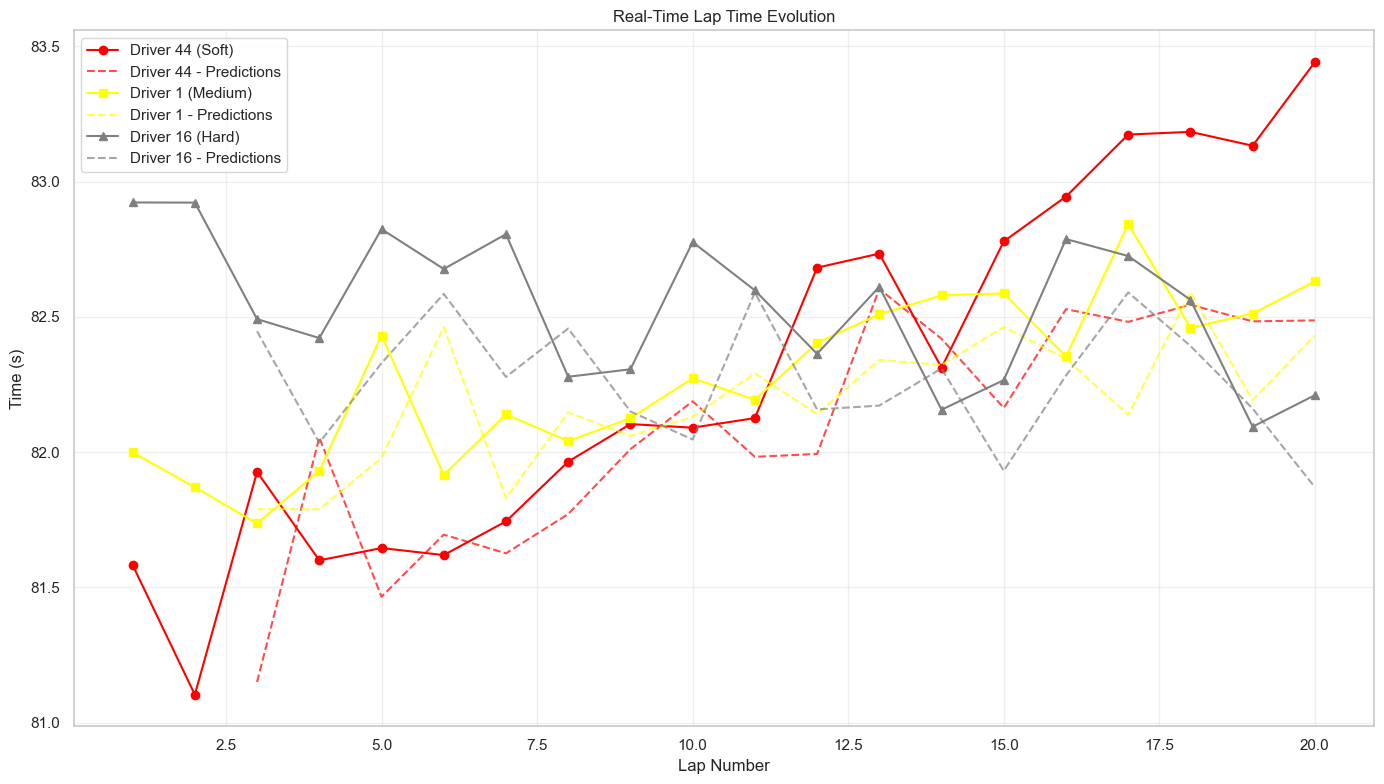

In [96]:
#Sim every 5 seconds
live_race_simulation(n_laps=20, update_interval=2.5)

# Final Point

For making inferences with this model, it is important to create a Python Module where a simple workflow is followed to use the model and use its predictions. For this purpose, in the following path: `../scripts/ML_tyre_pred/N00_model_lap_prediction.ipynb` there is a simple implementation for creating next the Python module using only a function that can be used in any part of the project for using this model.